In [18]:
# Imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve,accuracy_score,precision_recall_curve,plot_precision_recall_curve,average_precision_score

import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

In [20]:
try:
    import sweetviz
    print(sweetviz.__version__)
except:
    print(['[INFO] Install sweetviz'])
    !pip install sweetviz
    import sweetviz

2.1.0


In [21]:
try:
    df_sirio_libanes = pd.read_csv('https://raw.githubusercontent.com/BrunoASNascimento/bootcamp-datascience-alura/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.csv')
    print('[INFO] Loaded GitHub file.')
except:
    df_sirio_libanes = pd.read_excel('data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
    print('[INFO] Loaded local file.')

df_sirio_libanes.head()

[INFO] Loaded GitHub file.


Unnamed: 0  PATIENT_VISIT_IDENTIFIER  ...    WINDOW ICU
0           0                         0  ...       0-2   0
1           1                         0  ...       2-4   0
2           2                         0  ...       4-6   0
3           3                         0  ...      6-12   0
4           4                         0  ...  ABOVE_12   1

[5 rows x 232 columns]

In [22]:
df_sirio_libanes.tail()

Unnamed: 0  PATIENT_VISIT_IDENTIFIER  ...    WINDOW ICU
1920        1920                       384  ...       0-2   0
1921        1921                       384  ...       2-4   0
1922        1922                       384  ...       4-6   0
1923        1923                       384  ...      6-12   0
1924        1924                       384  ...  ABOVE_12   0

[5 rows x 232 columns]

In [23]:
df_sirio_libanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 232 entries, Unnamed: 0 to ICU
dtypes: float64(225), int64(5), object(2)
memory usage: 3.4+ MB


In [24]:
f"Número de pacientes: {df_sirio_libanes['PATIENT_VISIT_IDENTIFIER'].nunique()}"

'Número de pacientes: 385'

In [25]:
df_sirio_libanes.select_dtypes(include=['object']).columns

Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')

In [26]:
df_sirio_libanes_editado = df_sirio_libanes

In [27]:
df_sirio_libanes_editado['AGE_PERCENTIL']=df_sirio_libanes_editado['AGE_PERCENTIL'].astype("category")
df_sirio_libanes_editado['WINDOW']=df_sirio_libanes_editado['WINDOW'].astype("category")

In [28]:
df_sirio_libanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 232 entries, Unnamed: 0 to ICU
dtypes: category(2), float64(225), int64(5)
memory usage: 3.4 MB


In [68]:
correlacao_icu = df_sirio_libanes_editado.corr()['ICU'].abs()
correlacao_icu.head(20)

Unnamed: 0                  0.046708
PATIENT_VISIT_IDENTIFIER    0.047547
AGE_ABOVE65                 0.212198
GENDER                      0.065543
DISEASE GROUPING 1          0.061308
DISEASE GROUPING 2          0.081883
DISEASE GROUPING 3          0.077422
DISEASE GROUPING 4          0.057456
DISEASE GROUPING 5          0.087988
DISEASE GROUPING 6          0.006344
HTN                         0.170247
IMMUNOCOMPROMISED           0.014357
OTHER                       0.048225
ALBUMIN_MEDIAN              0.282270
ALBUMIN_MEAN                0.282270
ALBUMIN_MIN                 0.282270
ALBUMIN_MAX                 0.282270
ALBUMIN_DIFF                     NaN
BE_ARTERIAL_MEDIAN          0.298721
BE_ARTERIAL_MEAN            0.298721
Name: ICU, dtype: float64

In [ ]:
corelacao_filter = correlacao_icu.loc[(correlacao_icu>=0.3)&(~correlacao_icu.index.str.contains('MAX'))&(~correlacao_icu.index.str.contains('MIN'))&(~correlacao_icu.index.str.contains('MEDIAN'))]
corelacao_filter

In [30]:
window_list= df_sirio_libanes_editado['WINDOW'].drop_duplicates().to_list()
window_list

['0-2', '2-4', '4-6', '6-12', 'ABOVE_12']

In [31]:
list_filter = ['PATIENT_VISIT_IDENTIFIER','AGE_PERCENTIL']
df_evolucao_paciente=None
df_evolucao_paciente= df_sirio_libanes_editado[list_filter].drop_duplicates().reset_index(drop=True)
for field_data in list(corelacao_filter.index):
    for window_value in window_list:               
        df_evolucao_paciente[f'{field_data} ({window_value})'] = (
            df_sirio_libanes_editado.loc[(df_sirio_libanes_editado['WINDOW']==window_value)][field_data]
            )

In [32]:
df_evolucao_paciente.shape

(385, 72)

In [33]:
age_list= df_sirio_libanes_editado['AGE_PERCENTIL'].drop_duplicates().to_list()
age_list

['60th',
 '90th',
 '10th',
 '40th',
 '70th',
 '20th',
 '50th',
 '80th',
 '30th',
 'Above 90th']

In [34]:
df_evolucao_paciente.head()

PATIENT_VISIT_IDENTIFIER AGE_PERCENTIL  ...  ICU (6-12)  ICU (ABOVE_12)
0                         0          60th  ...         NaN             NaN
1                         1          90th  ...         NaN             NaN
2                         2          10th  ...         NaN             NaN
3                         3          40th  ...         0.0             NaN
4                         4          10th  ...         NaN             1.0

[5 rows x 72 columns]

In [35]:
icu_list=[icu_value for icu_value in df_evolucao_paciente.columns if 'ICU' in icu_value]
icu_list

['ICU (0-2)', 'ICU (2-4)', 'ICU (4-6)', 'ICU (6-12)', 'ICU (ABOVE_12)']

In [36]:
df_evolucao_paciente[icu_list].describe()

ICU (0-2)  ICU (2-4)  ICU (4-6)  ICU (6-12)  ICU (ABOVE_12)
count  77.000000  77.000000  77.000000   77.000000       77.000000
mean    0.103896   0.142857   0.298701    0.376623        0.467532
std     0.307127   0.352222   0.460690    0.487717        0.502217
min     0.000000   0.000000   0.000000    0.000000        0.000000
25%     0.000000   0.000000   0.000000    0.000000        0.000000
50%     0.000000   0.000000   0.000000    0.000000        0.000000
75%     0.000000   0.000000   1.000000    1.000000        1.000000
max     1.000000   1.000000   1.000000    1.000000        1.000000

In [37]:
df_evolucao_paciente['ICU'] = df_evolucao_paciente[icu_list].sum(axis = 1, skipna = True)

In [38]:
df_evolucao_paciente.drop(columns=icu_list,inplace=True,errors='ignore')
df_evolucao_paciente.head()

PATIENT_VISIT_IDENTIFIER AGE_PERCENTIL  ...  TEMPERATURE_DIFF_REL (ABOVE_12)  ICU
0                         0          60th  ...                              NaN  0.0
1                         1          90th  ...                              NaN  0.0
2                         2          10th  ...                              NaN  0.0
3                         3          40th  ...                              NaN  0.0
4                         4          10th  ...                        -0.242282  1.0

[5 rows x 68 columns]

In [39]:
df_evolucao_paciente['ICU'].describe()

count    385.000000
mean       0.277922
std        0.448558
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: ICU, dtype: float64

In [40]:
df_evolucao_paciente['ICU'].value_counts(normalize=True).round(3)

0.0    0.722
1.0    0.278
Name: ICU, dtype: float64

In [41]:
report = sweetviz.analyze(df_evolucao_paciente,pairwise_analysis='on')

                                             |          | [  0%]   00:00 -> (? left)


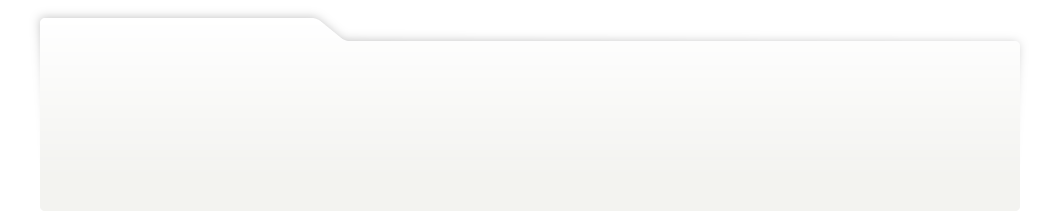
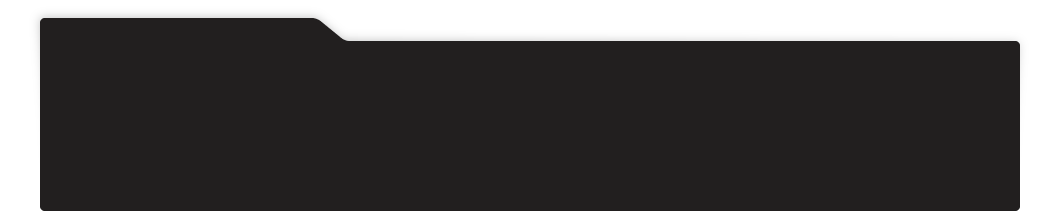
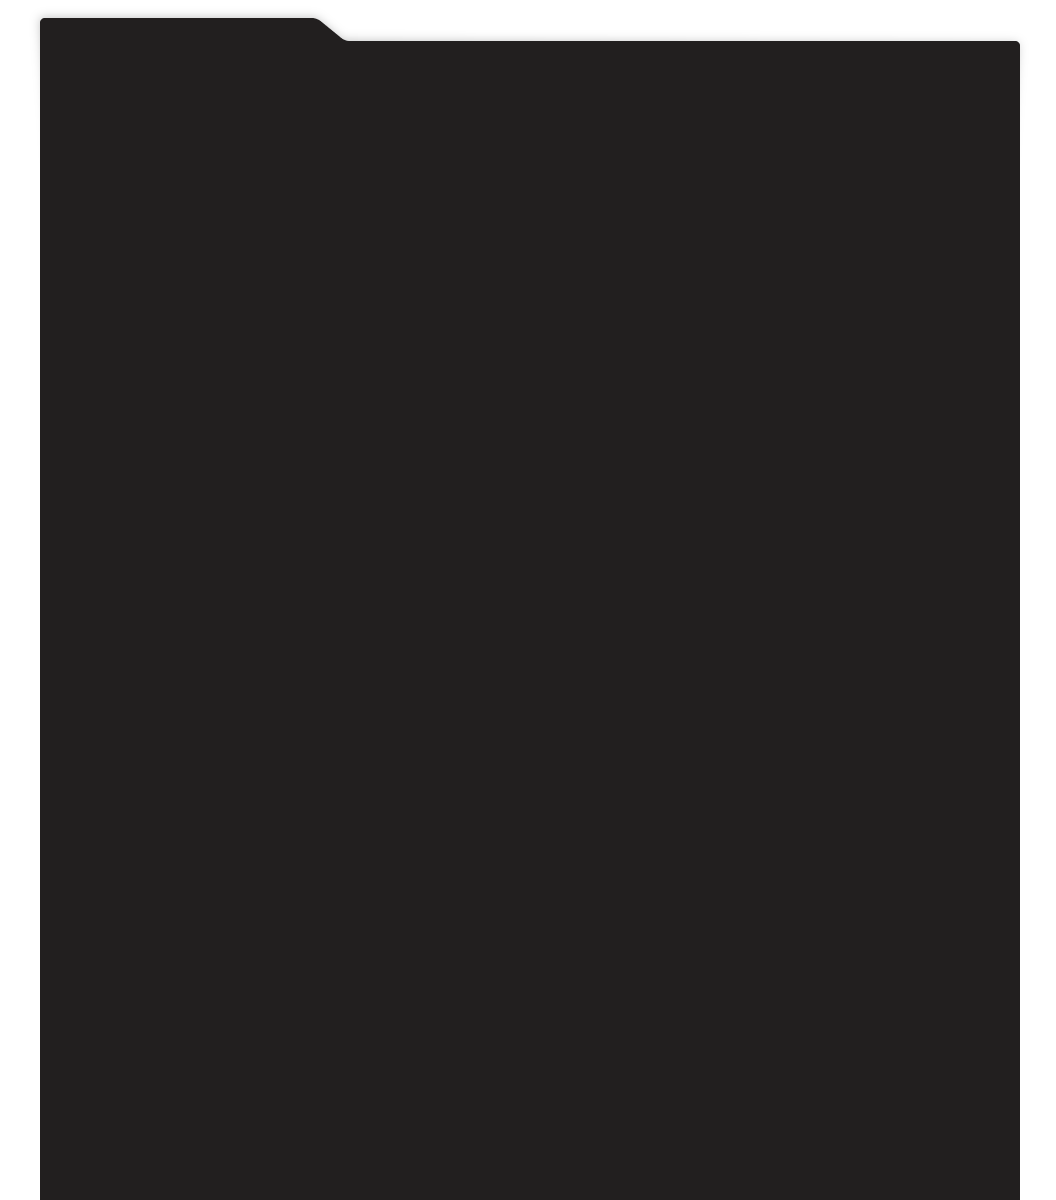
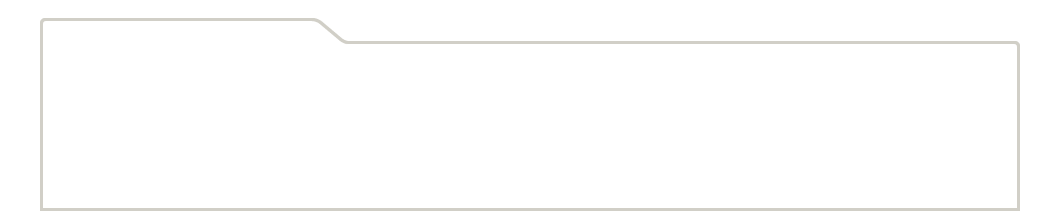
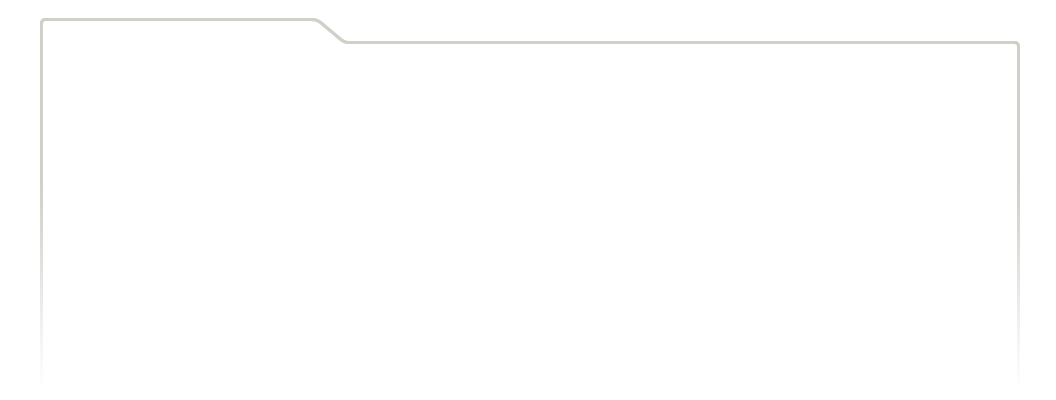
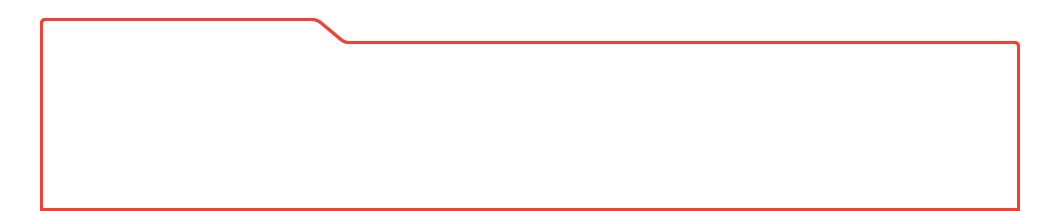
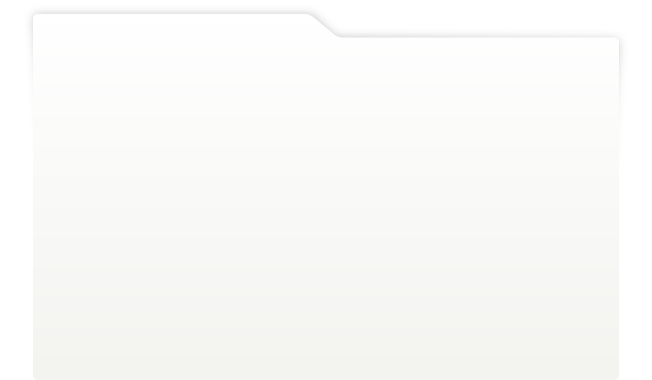
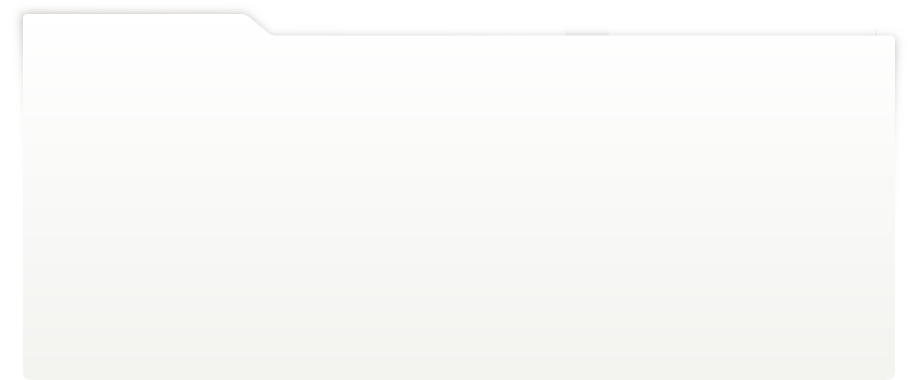
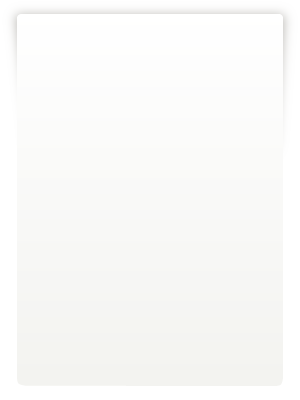
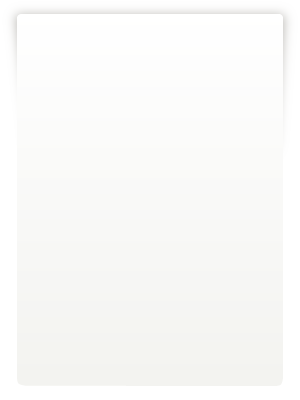
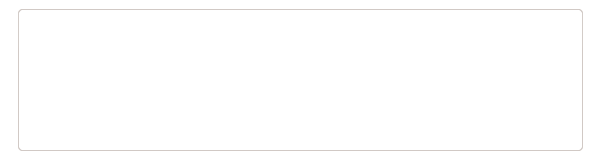
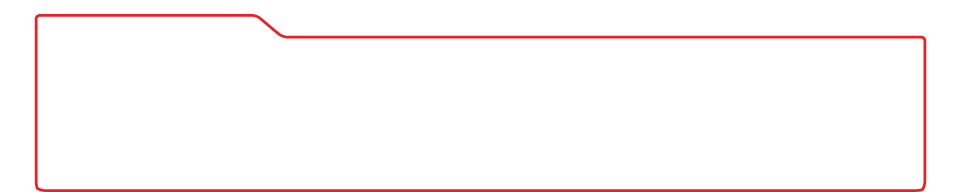
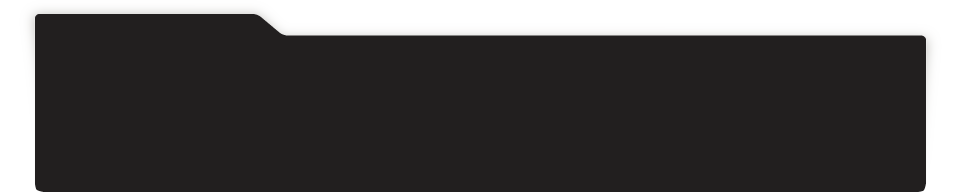
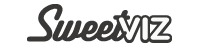
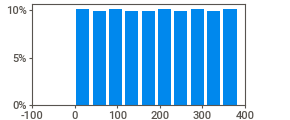
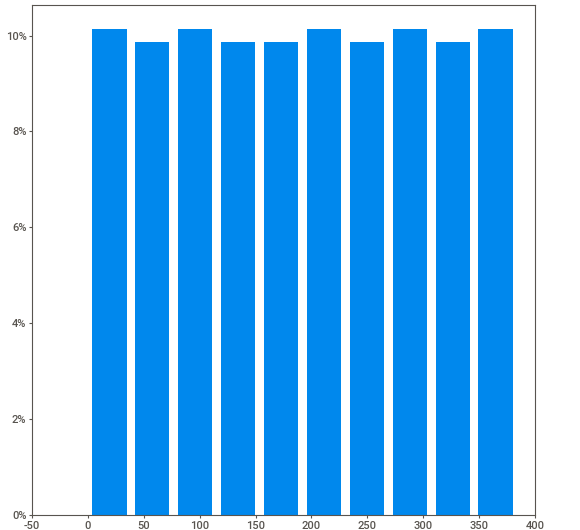
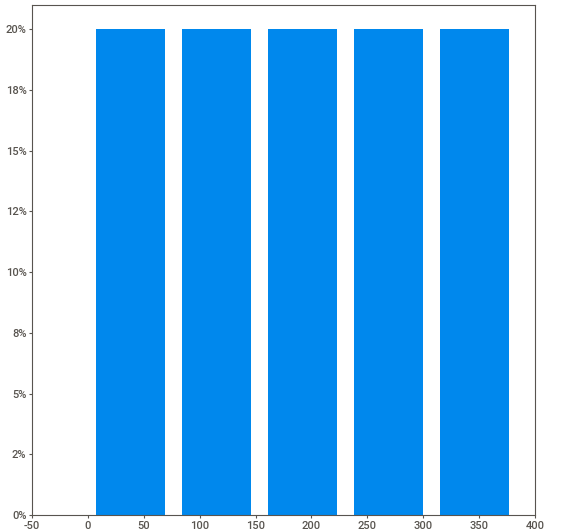
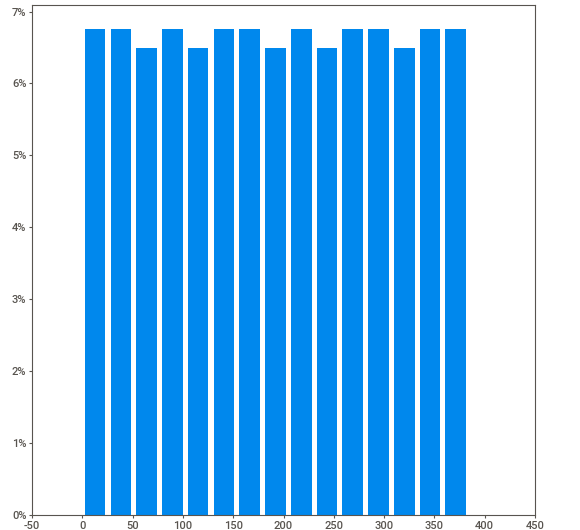
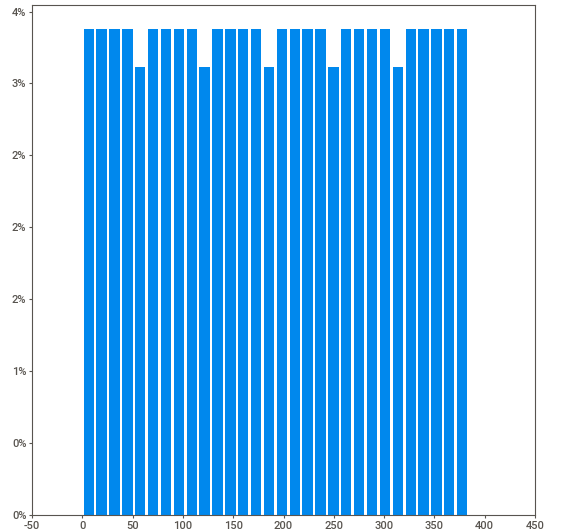
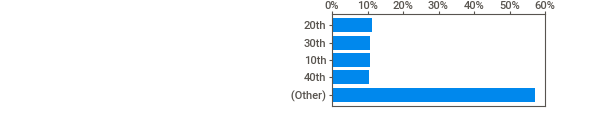
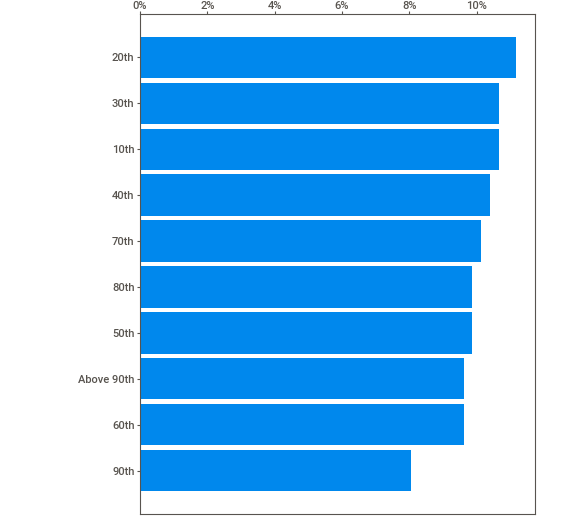
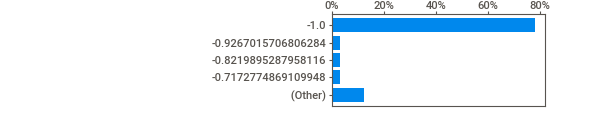
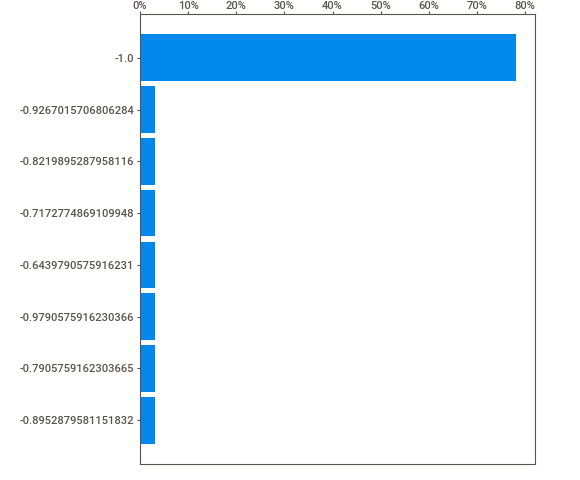
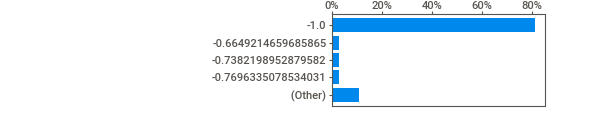
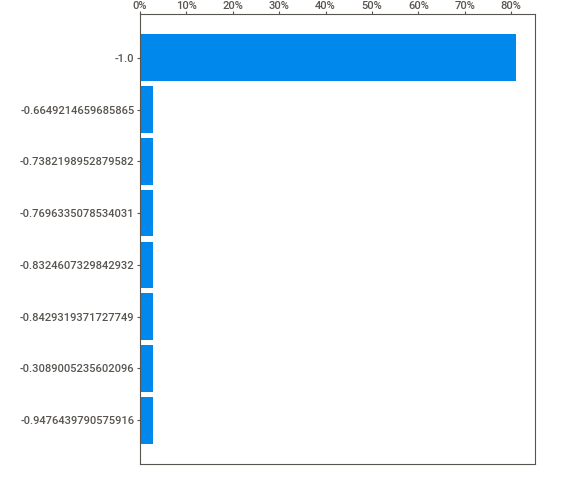
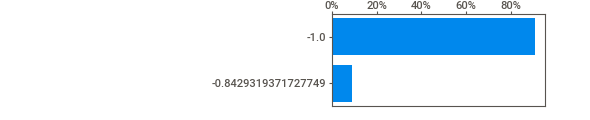
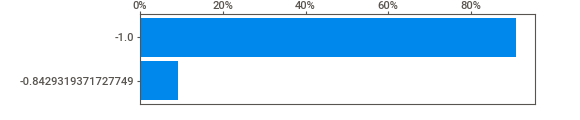
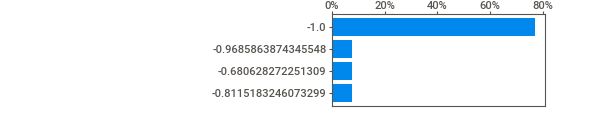
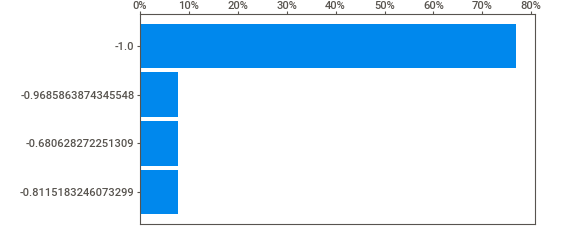
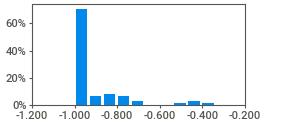
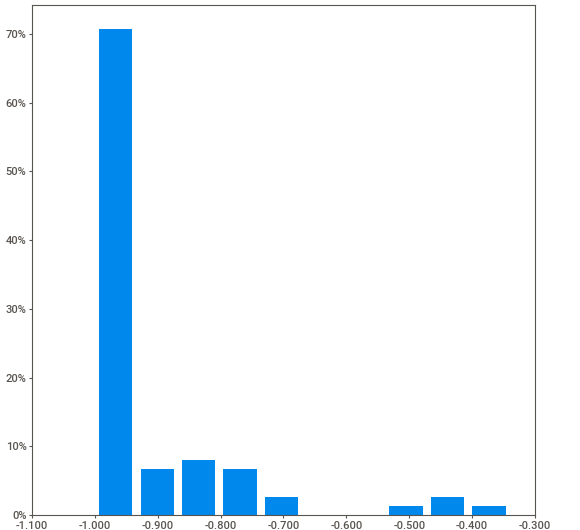
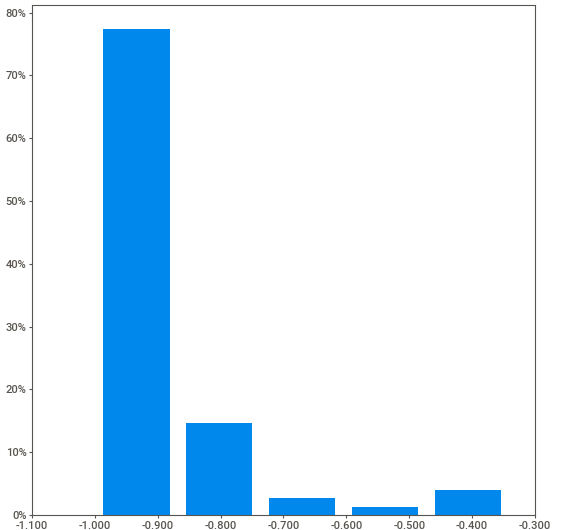
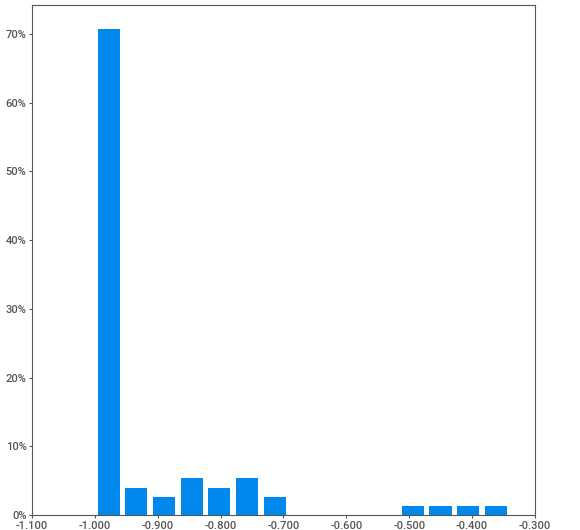
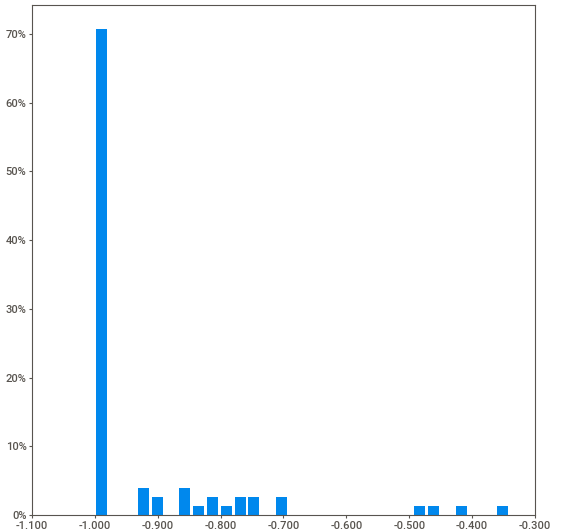
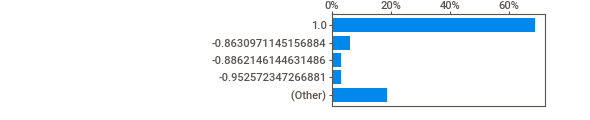
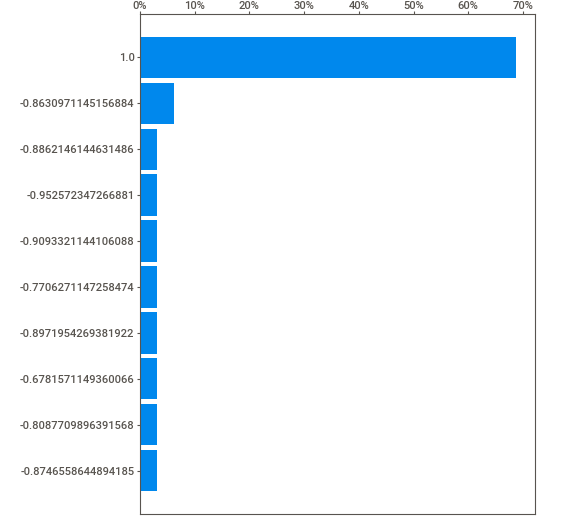
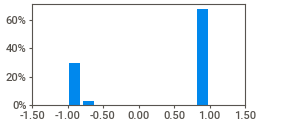
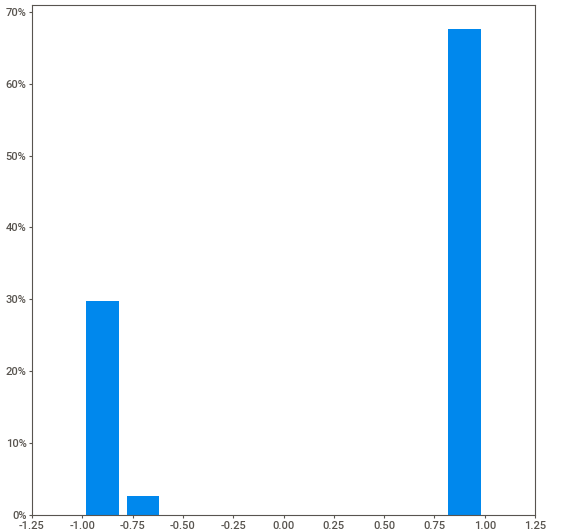
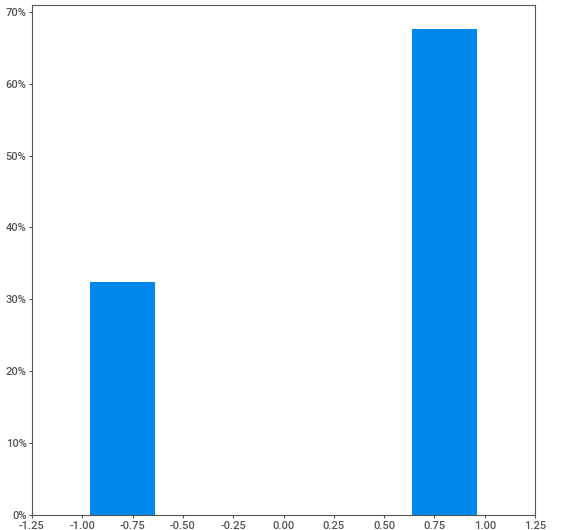
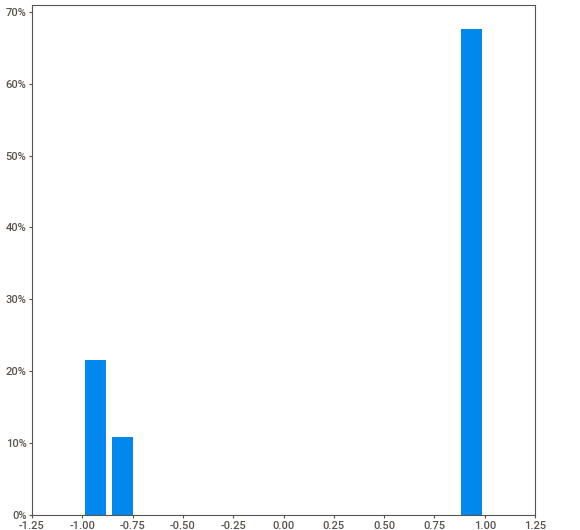
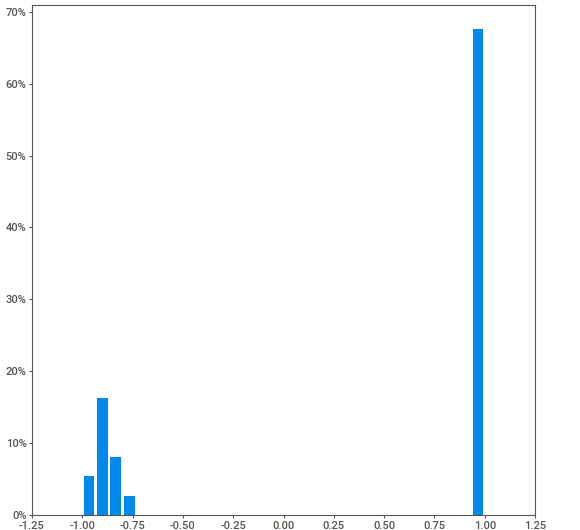
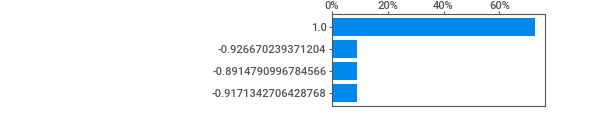
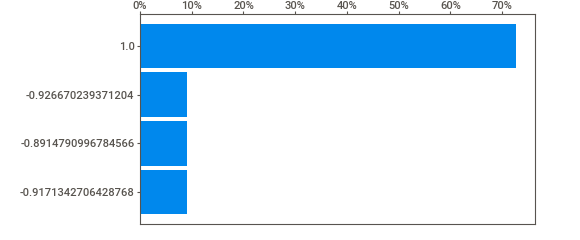
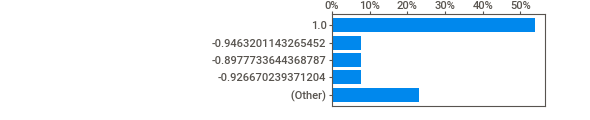
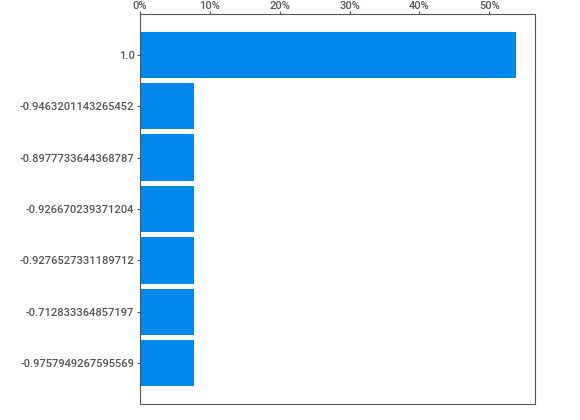
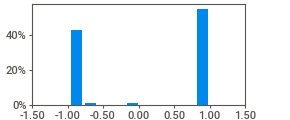
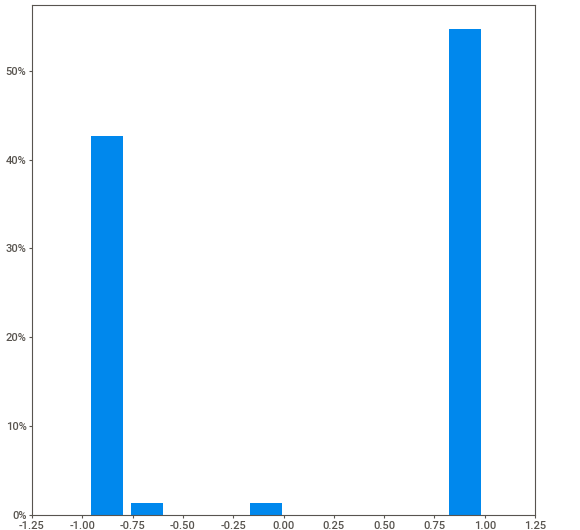
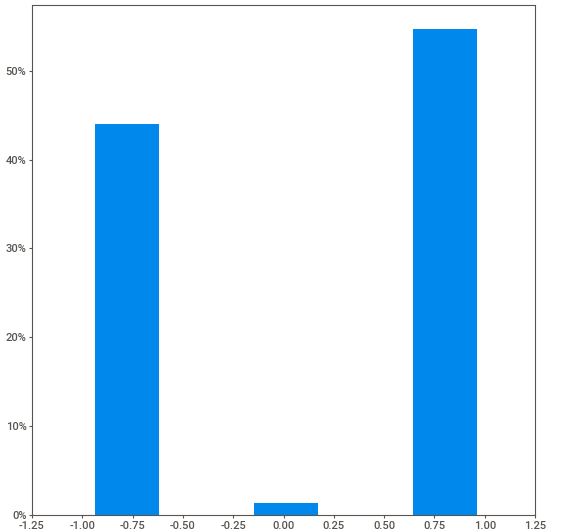
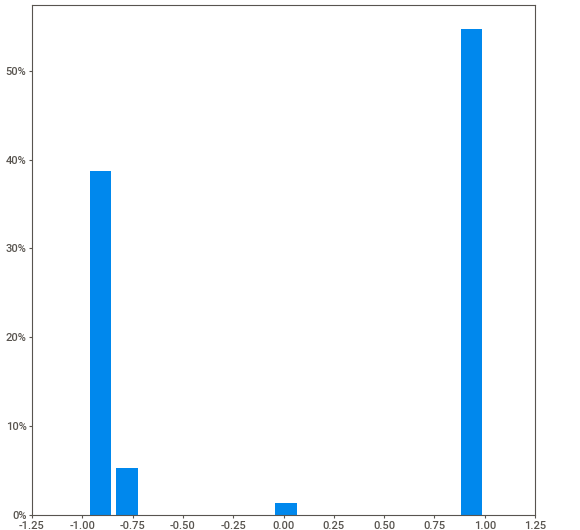
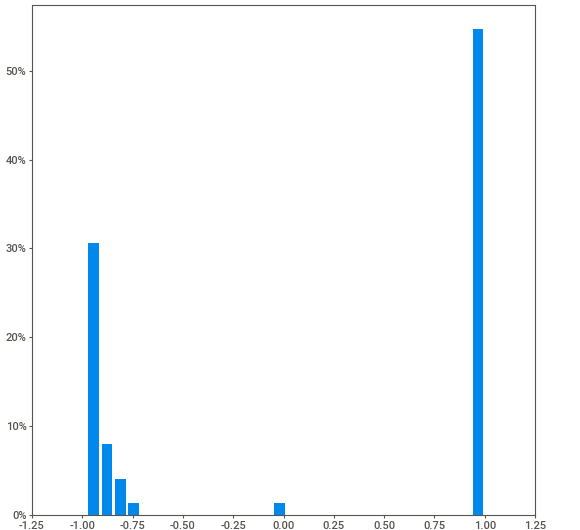
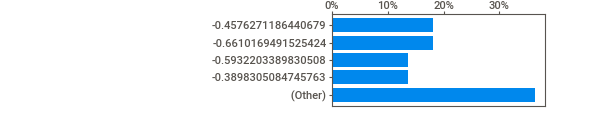
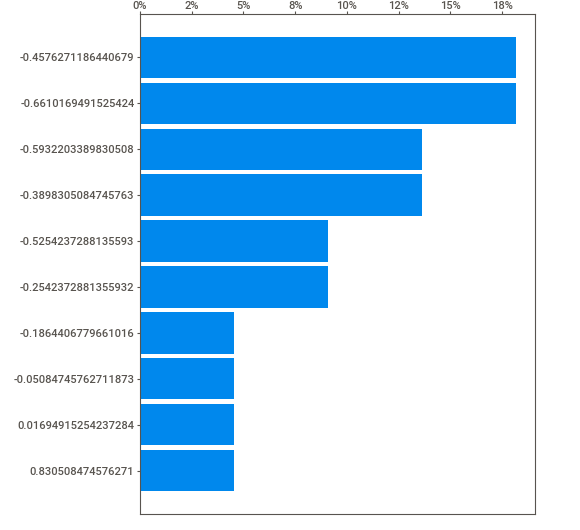
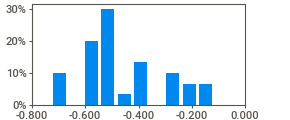
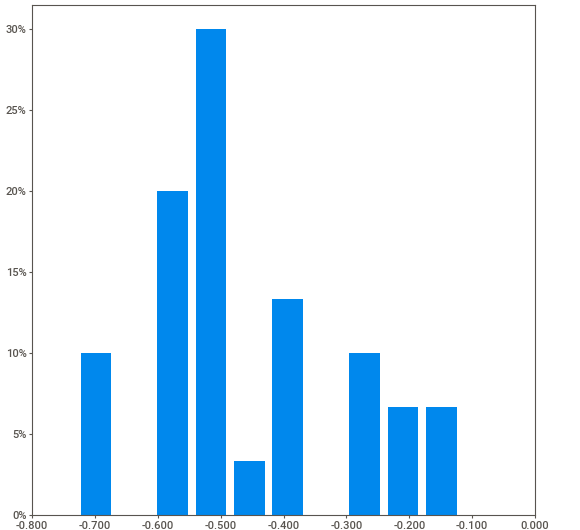
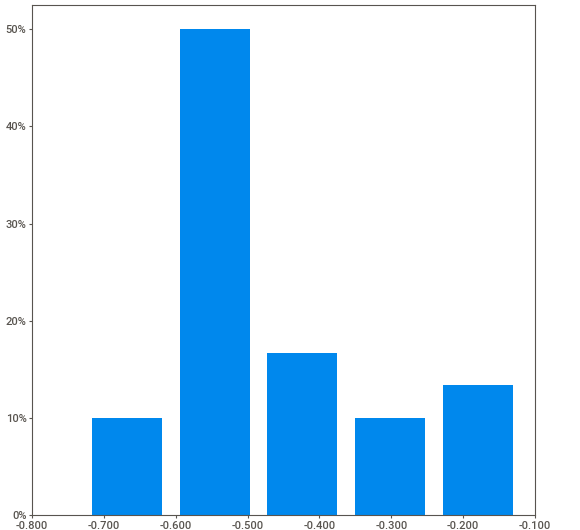
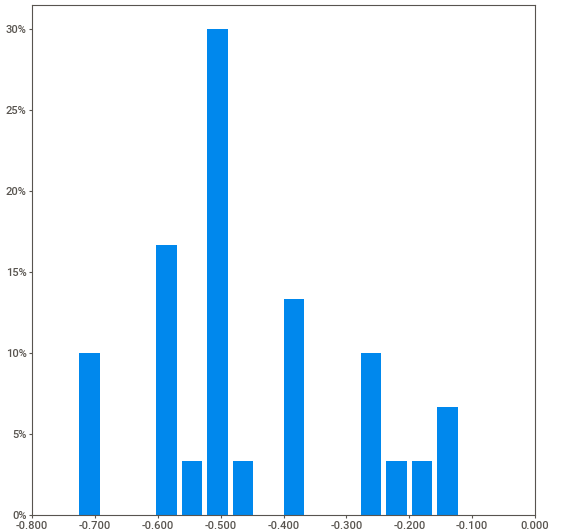
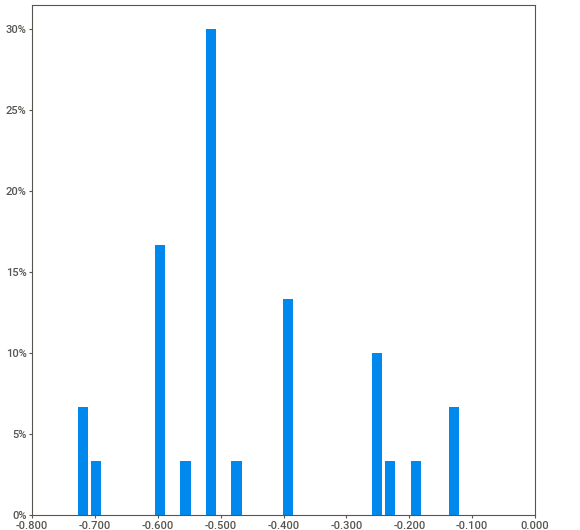
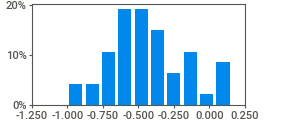
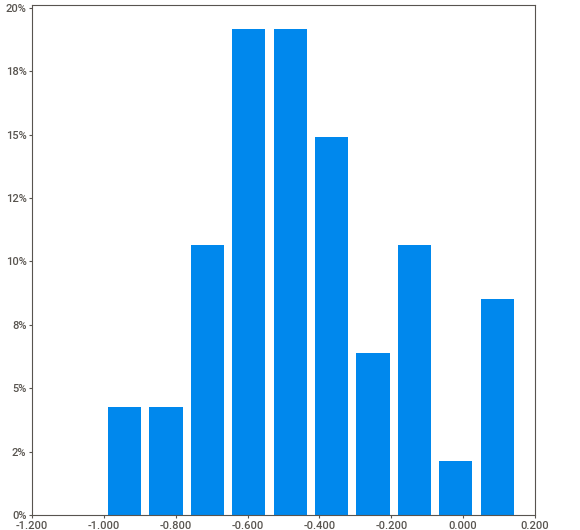
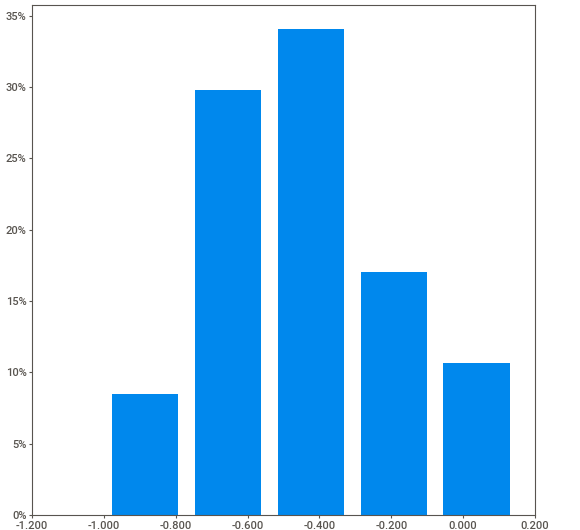
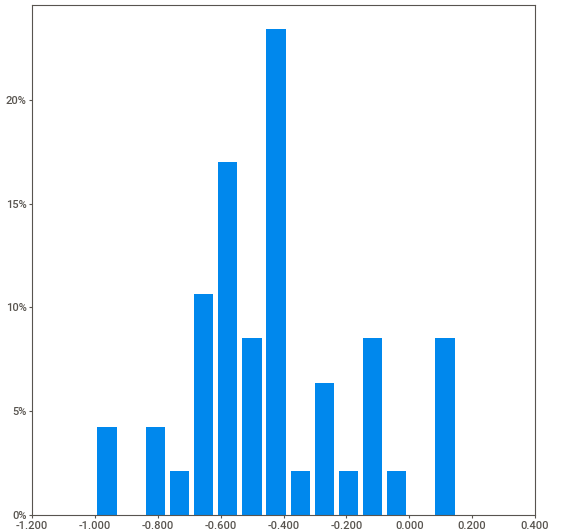
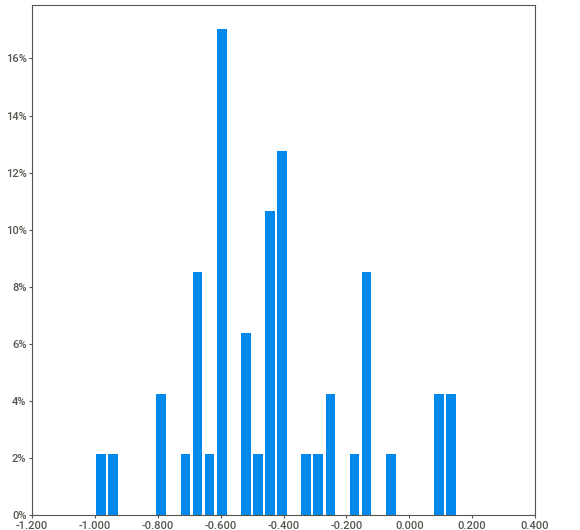
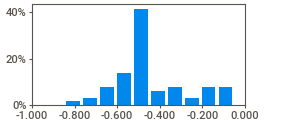
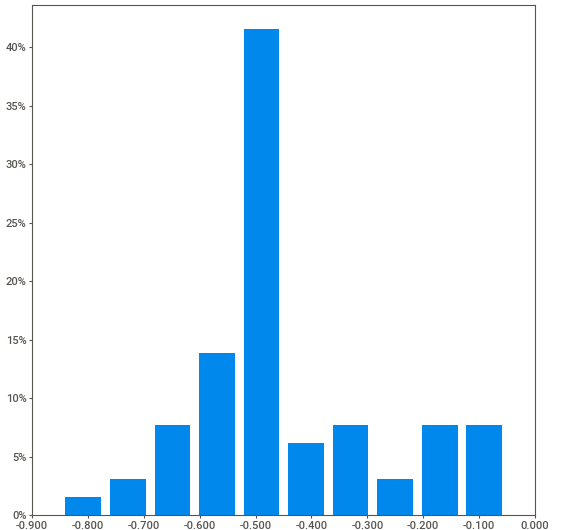
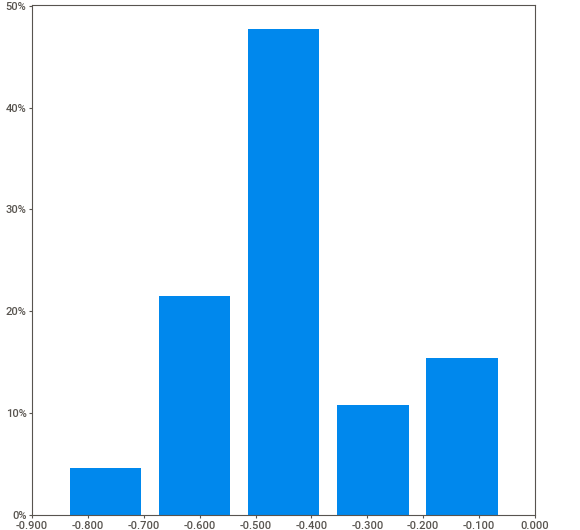
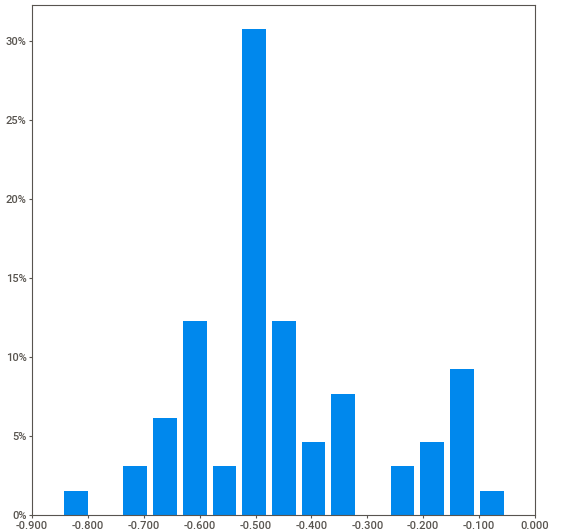
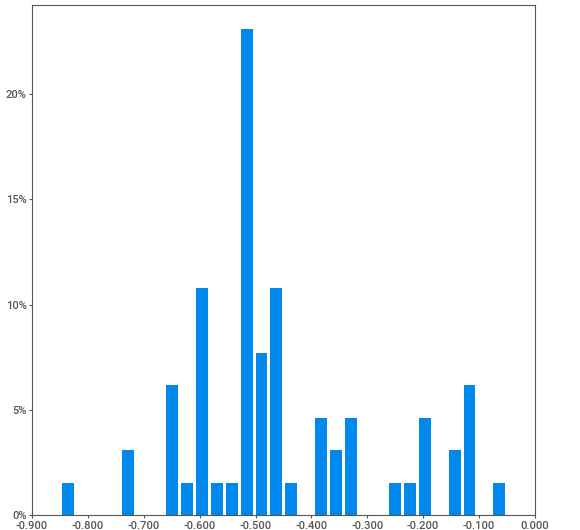
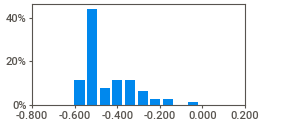
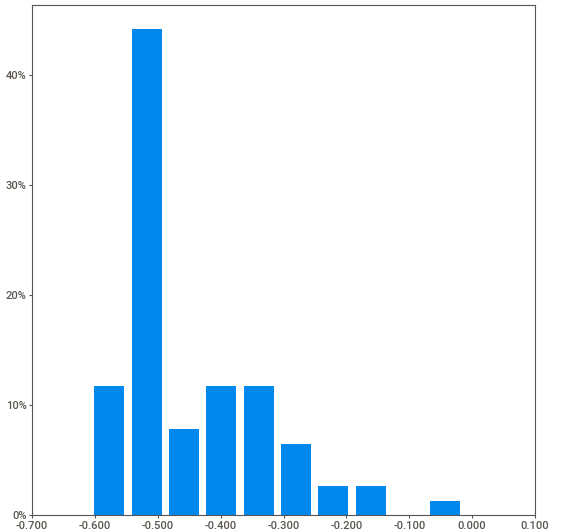
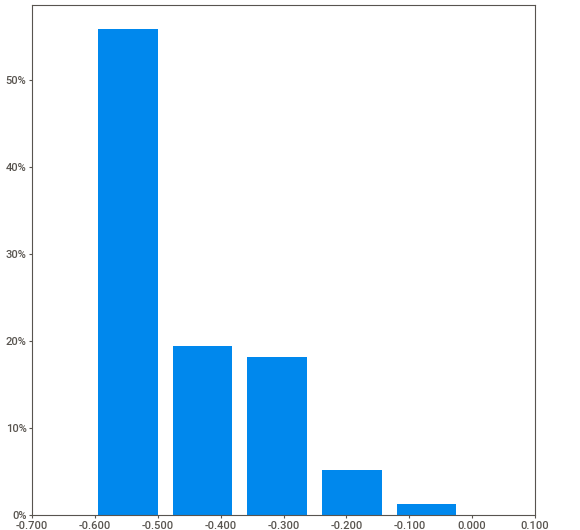
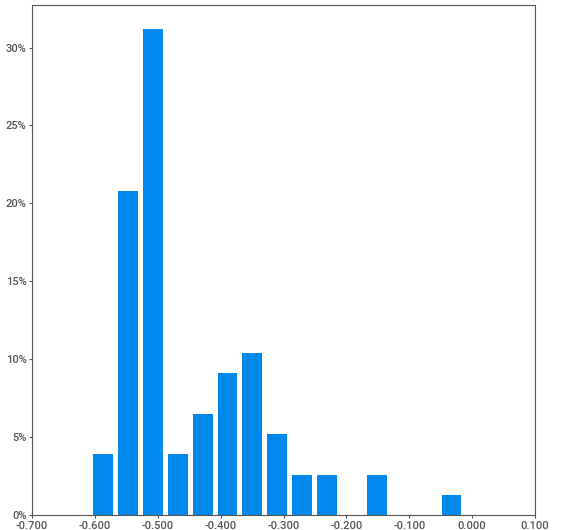
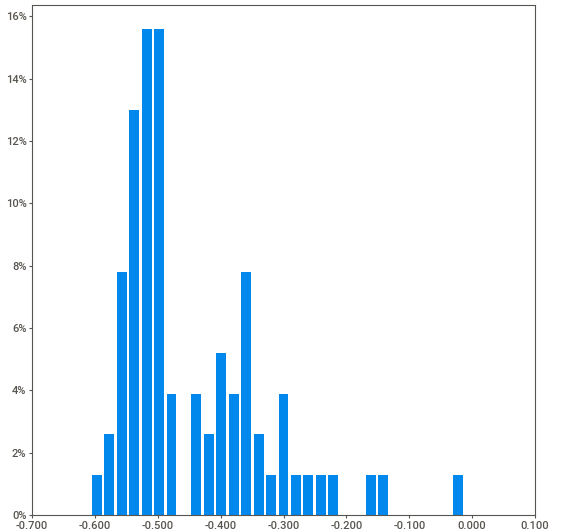
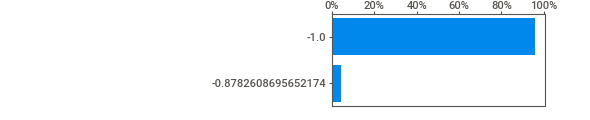
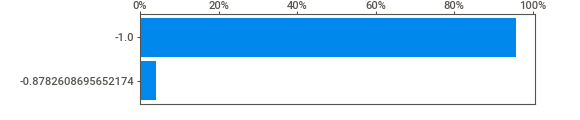
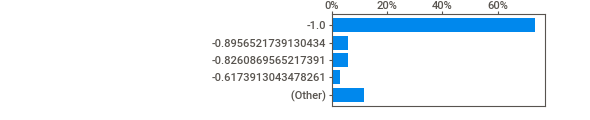
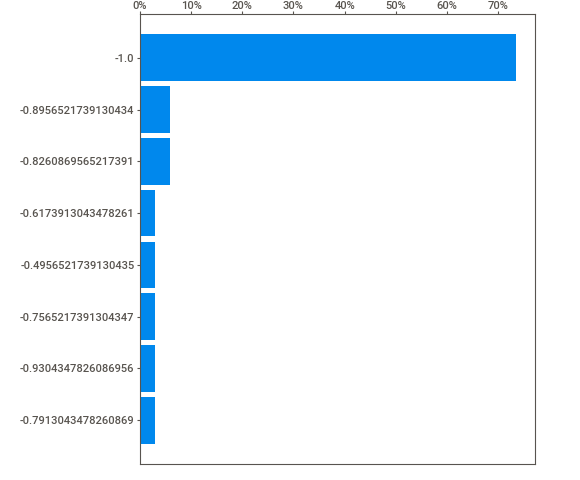
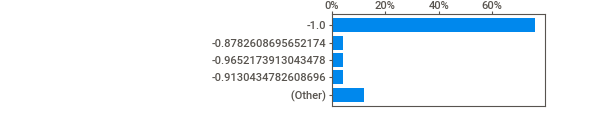
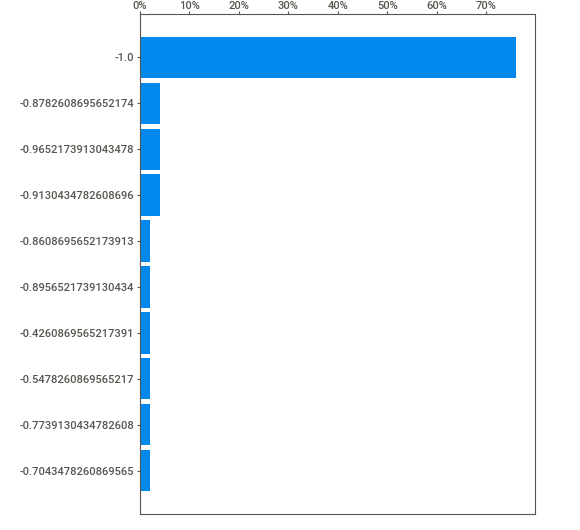
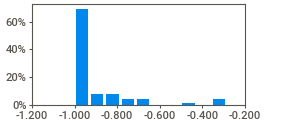
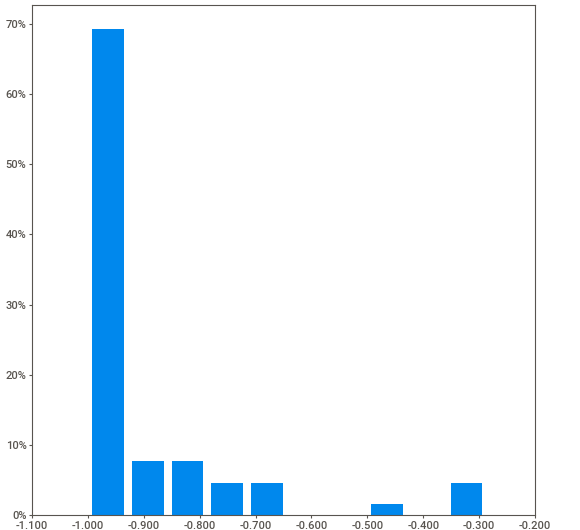
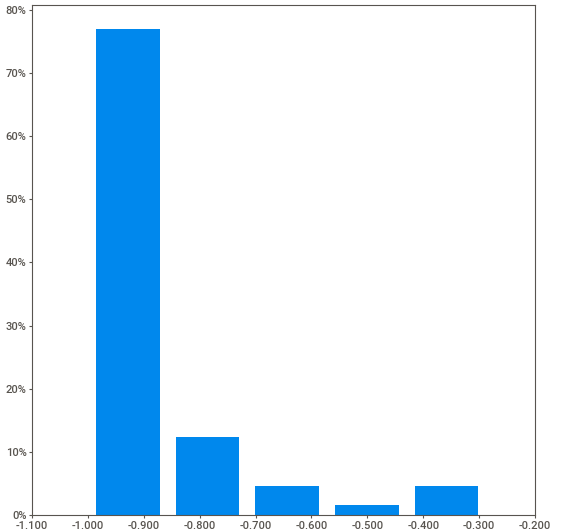
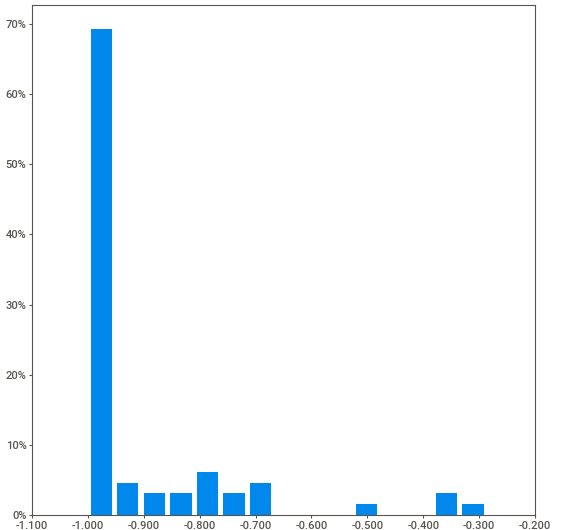
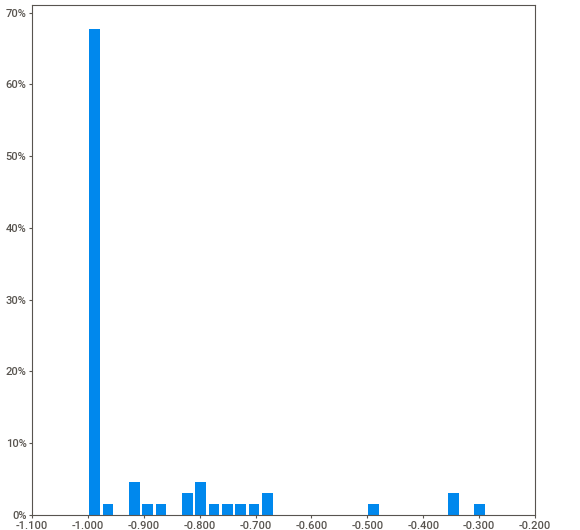
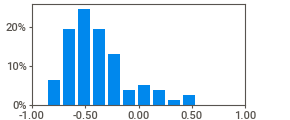
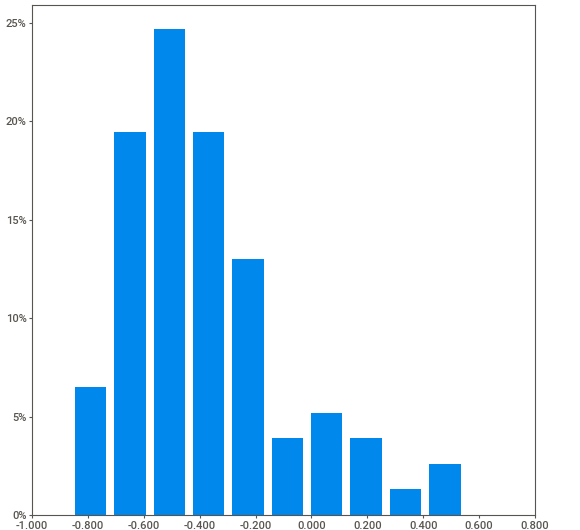
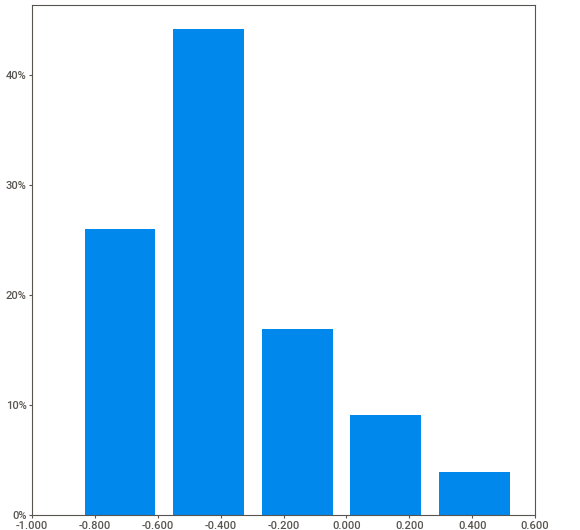
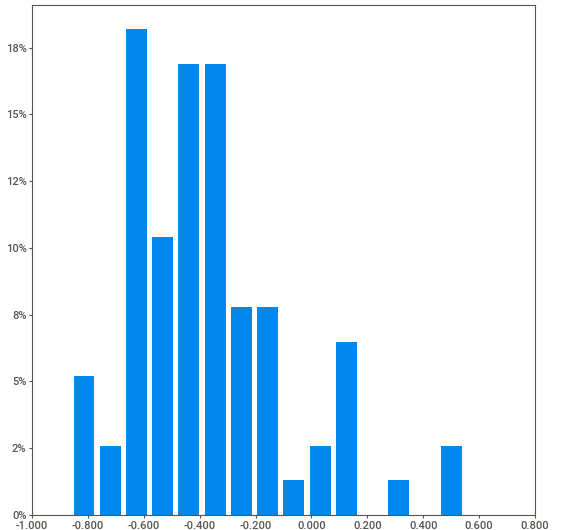
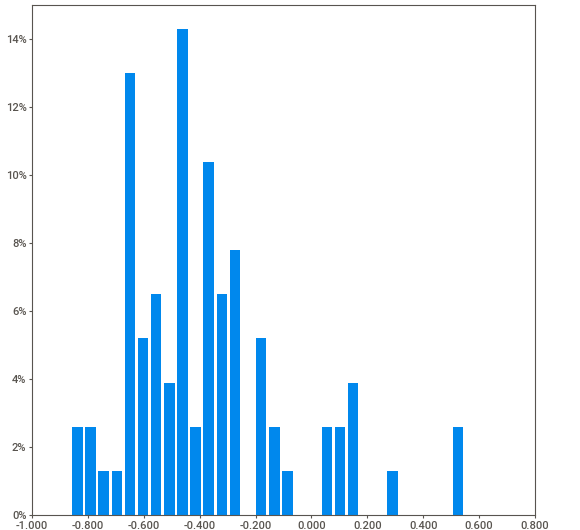
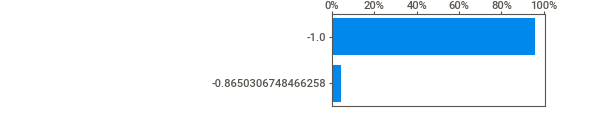
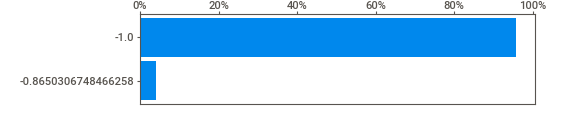
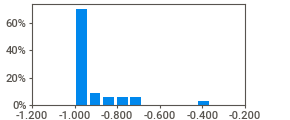
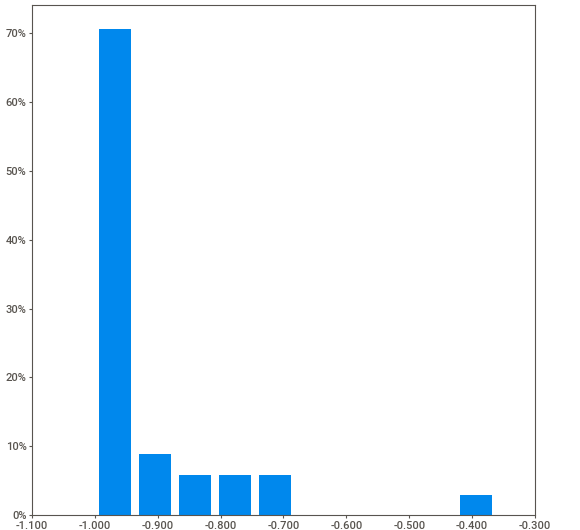
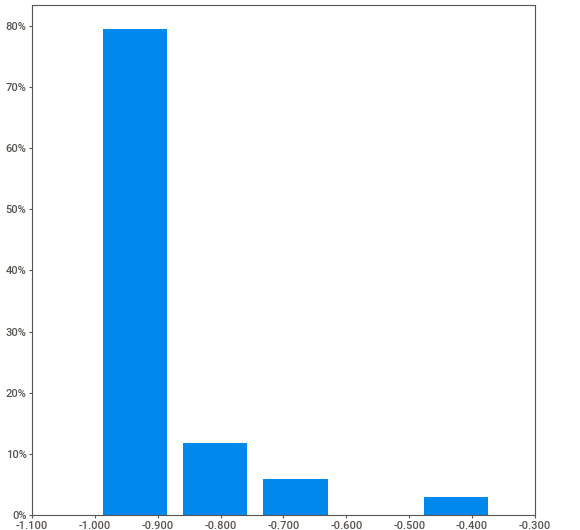
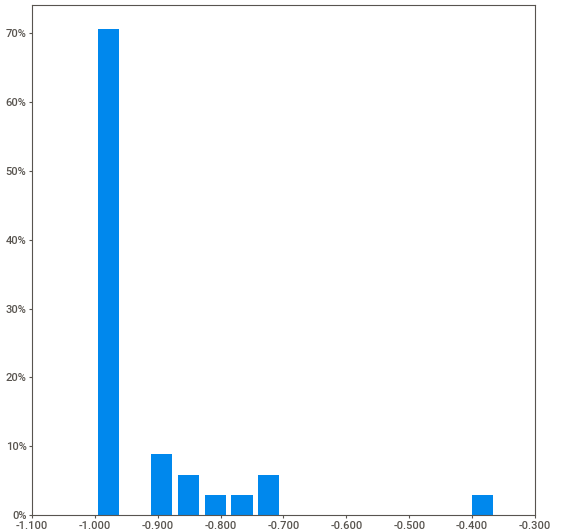
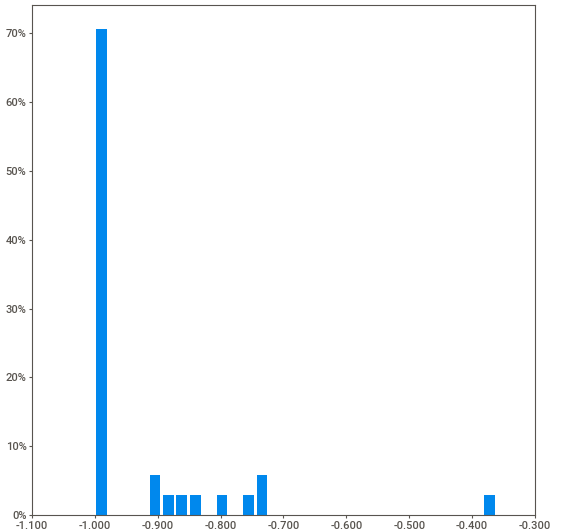
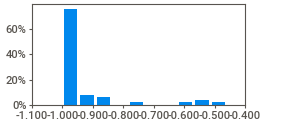
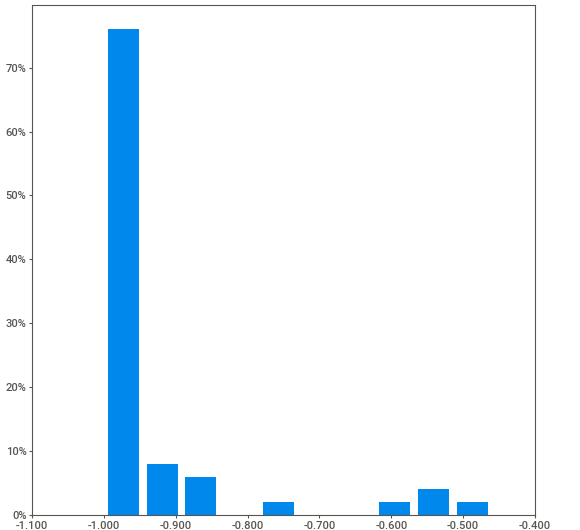
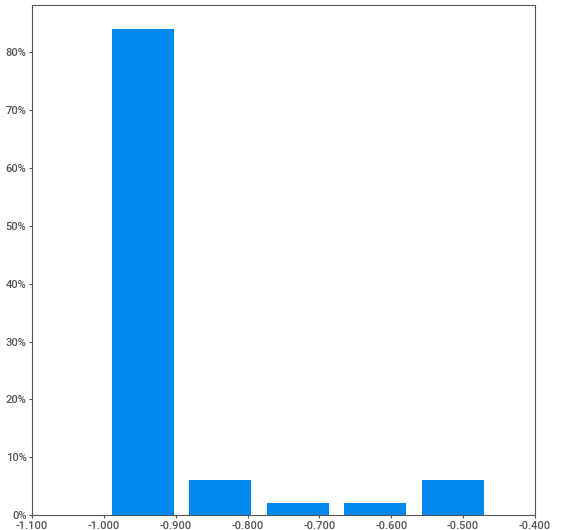
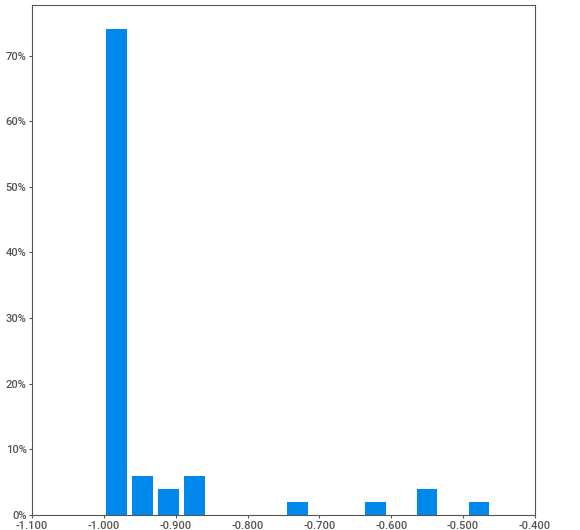
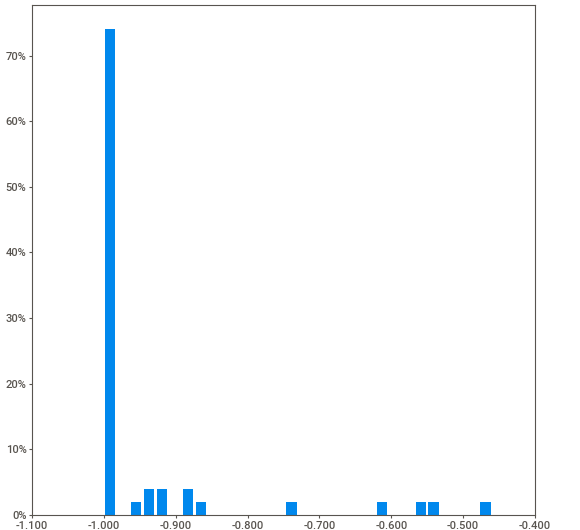
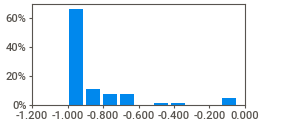
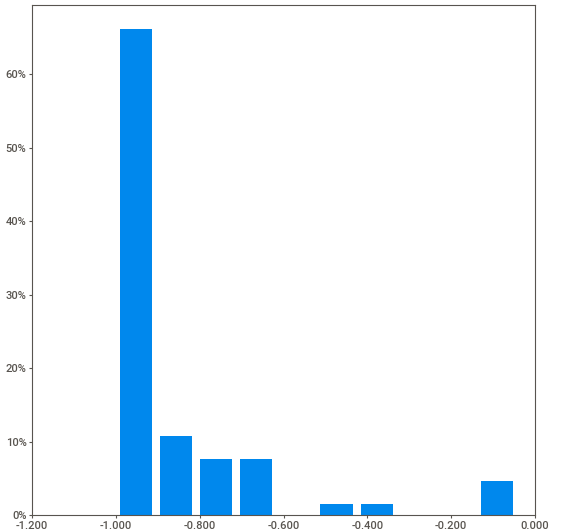
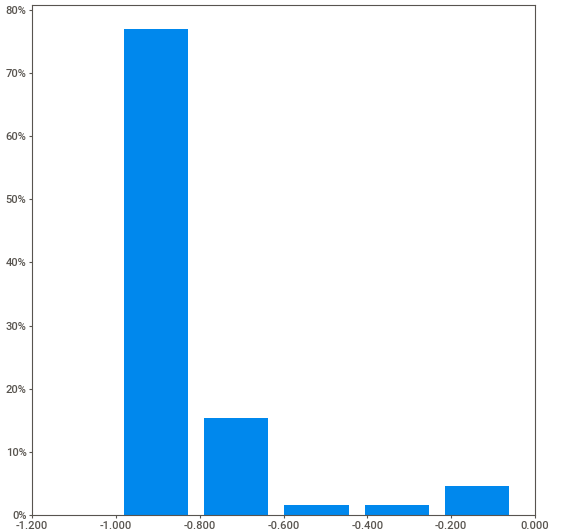
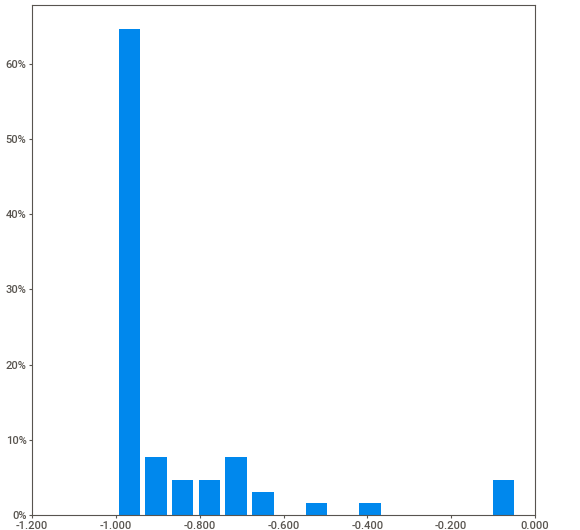
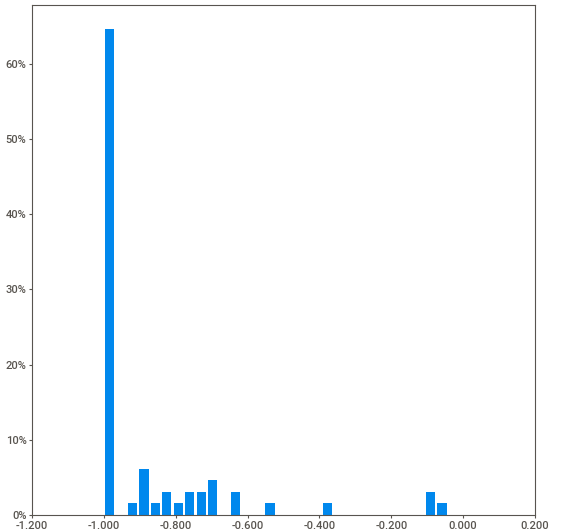
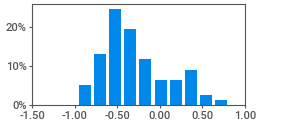
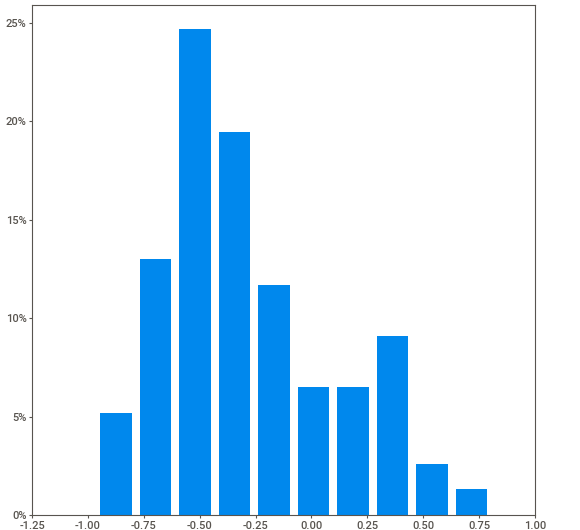
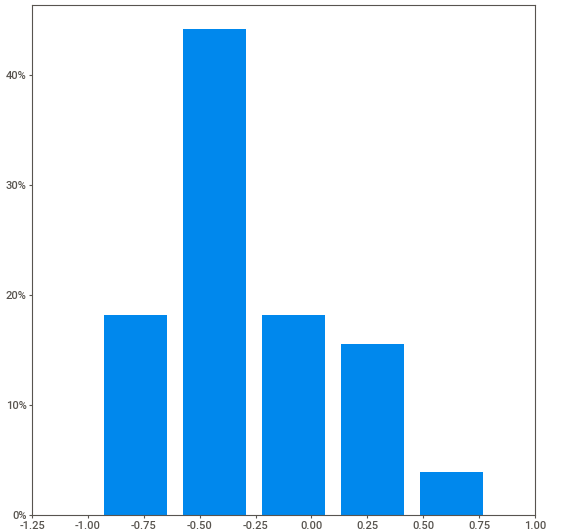
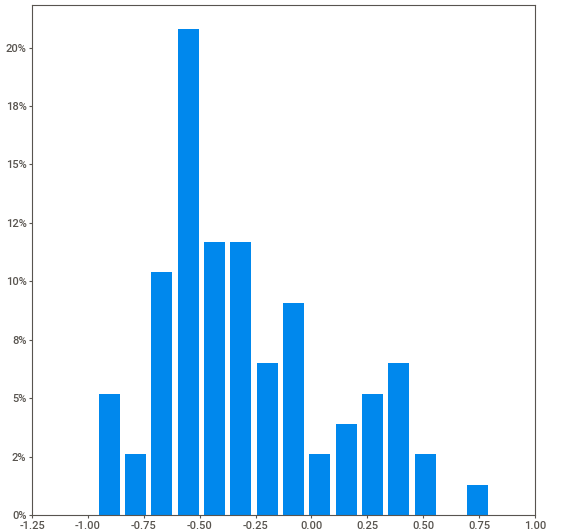
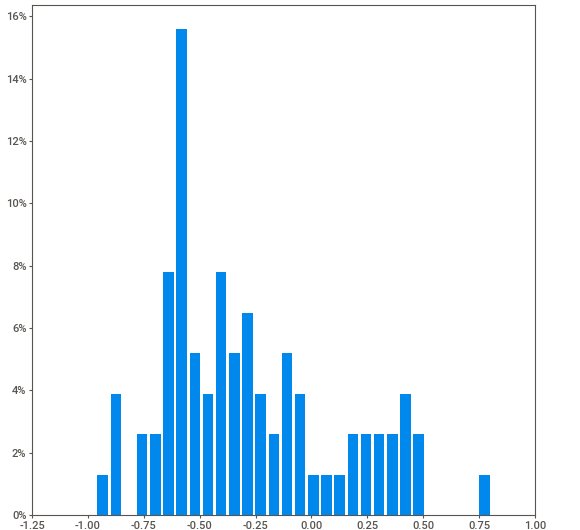
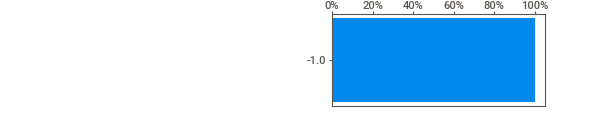
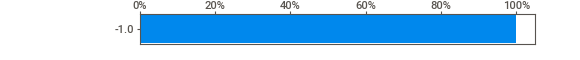
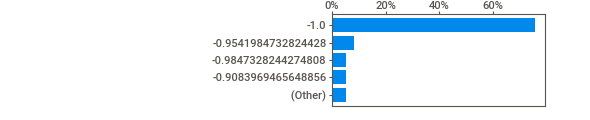
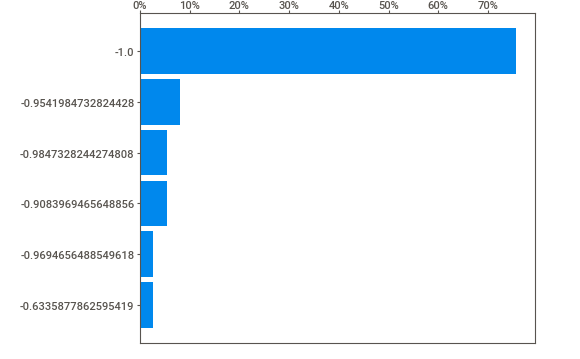
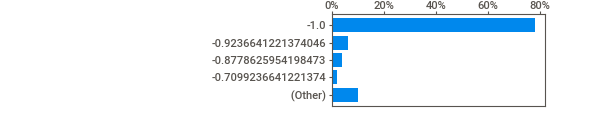
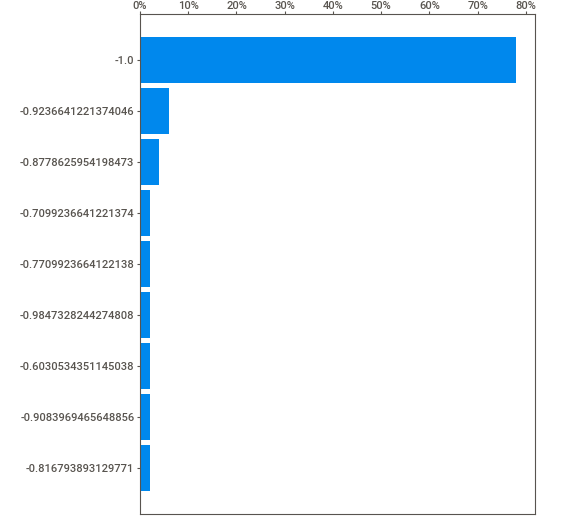
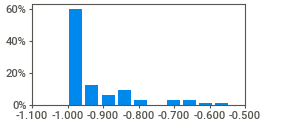
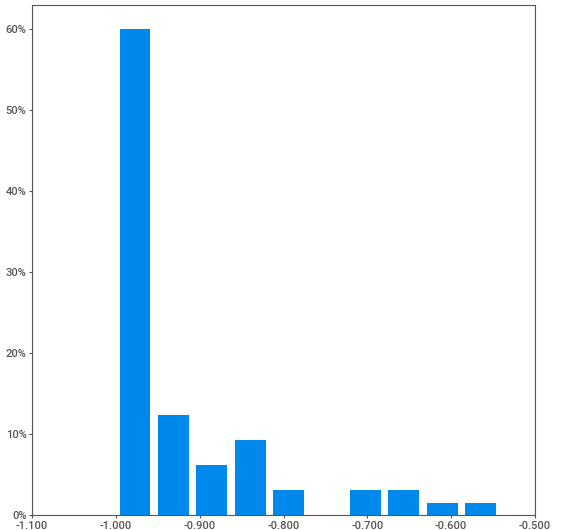
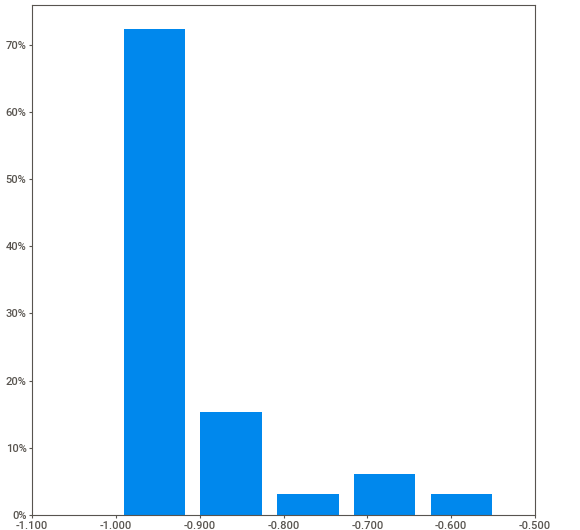
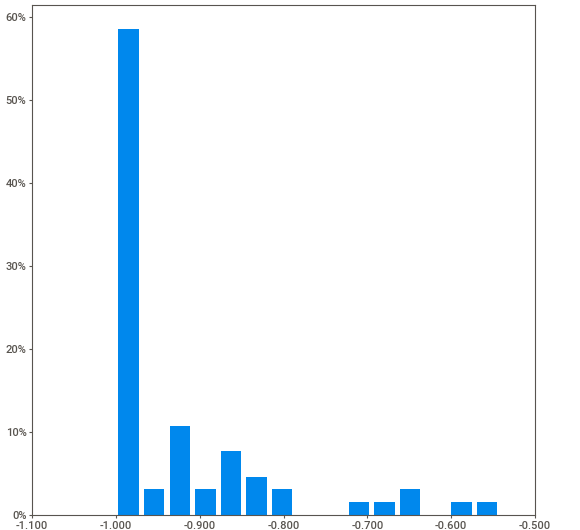
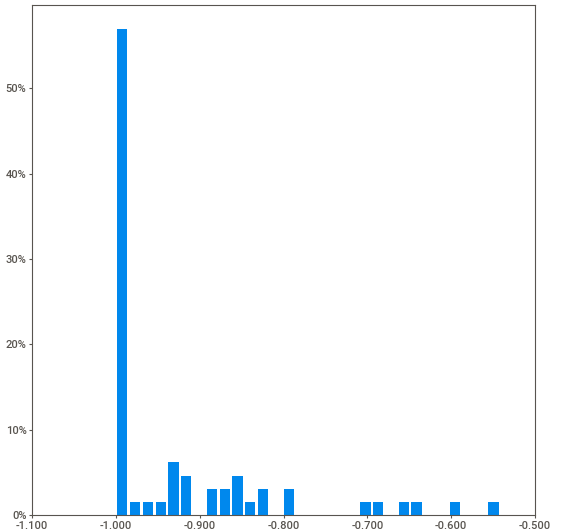
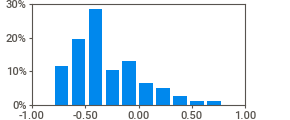
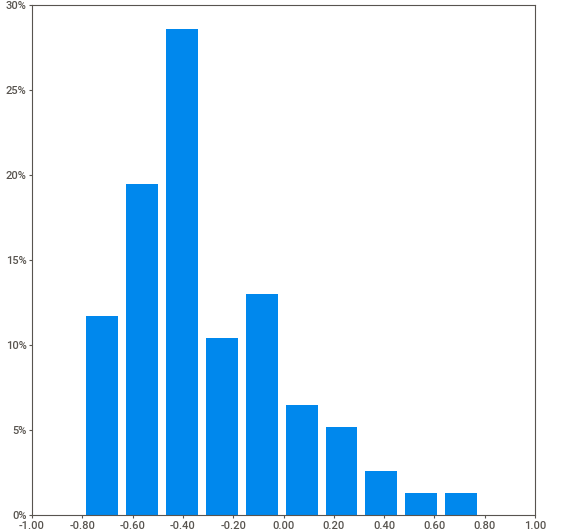
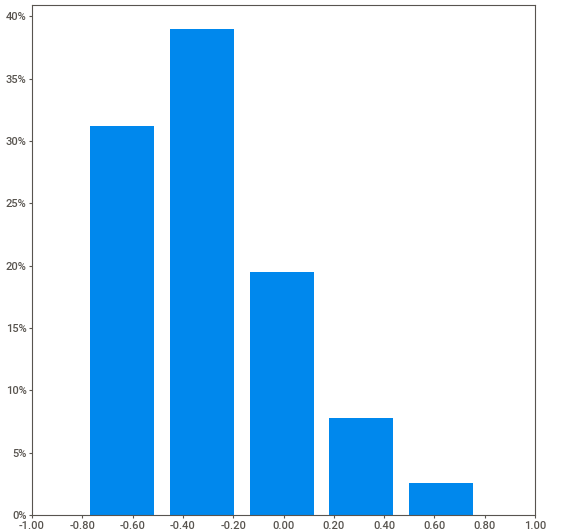
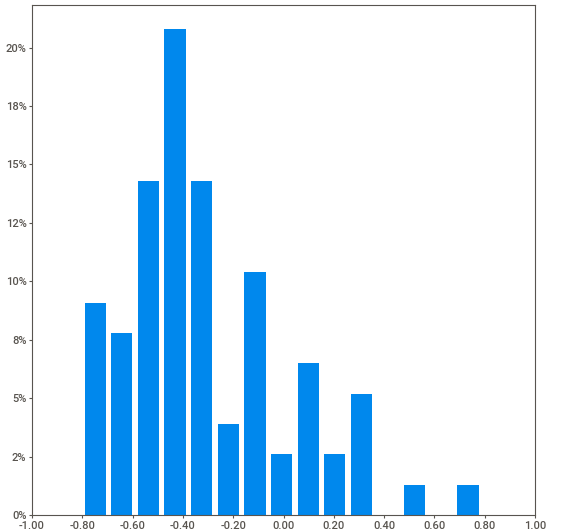
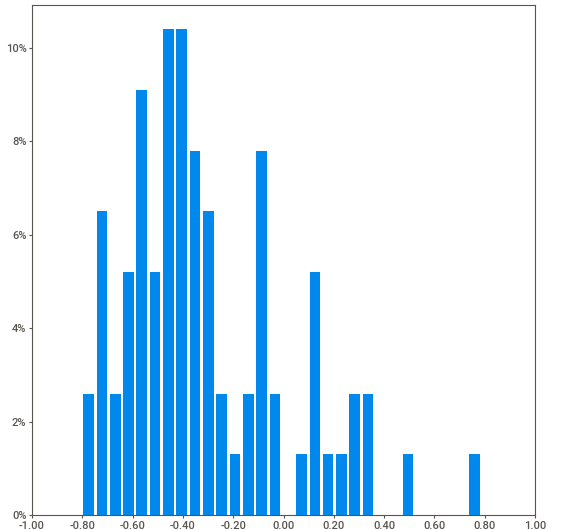
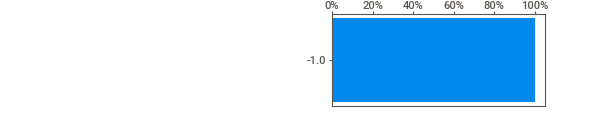
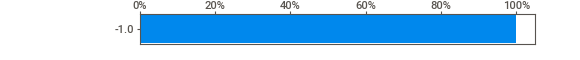
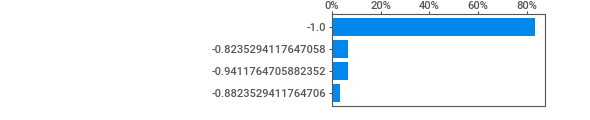
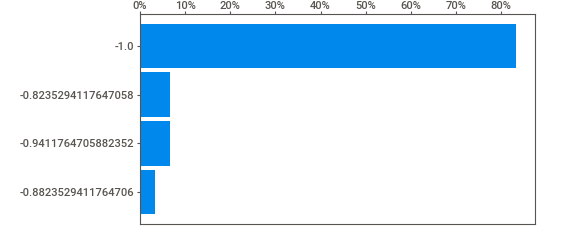
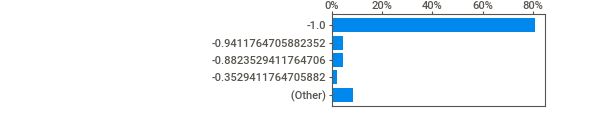
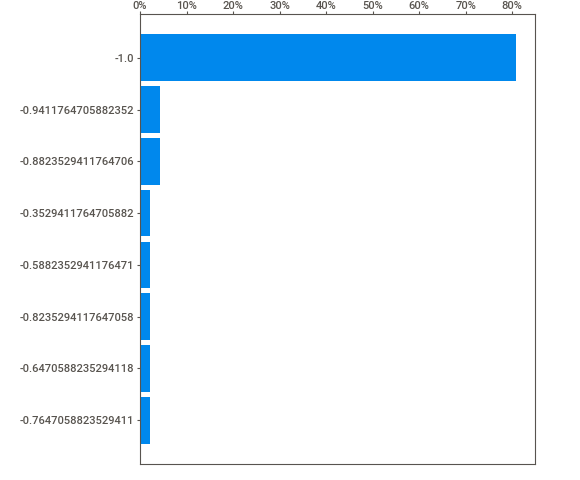
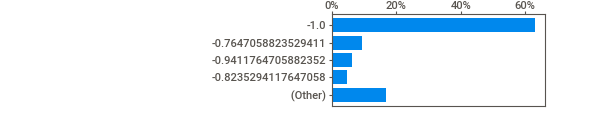
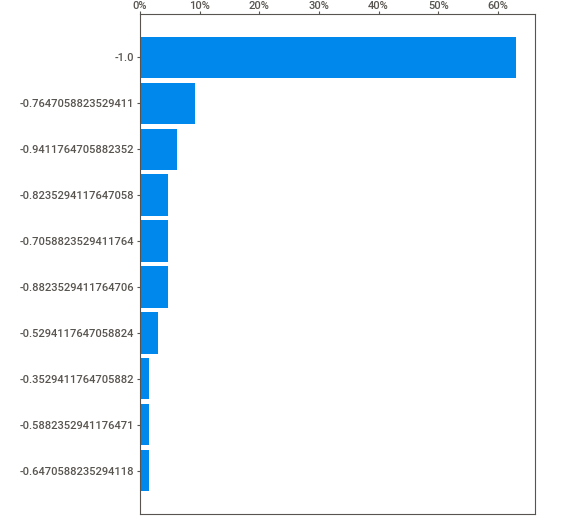
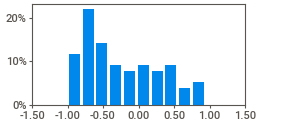
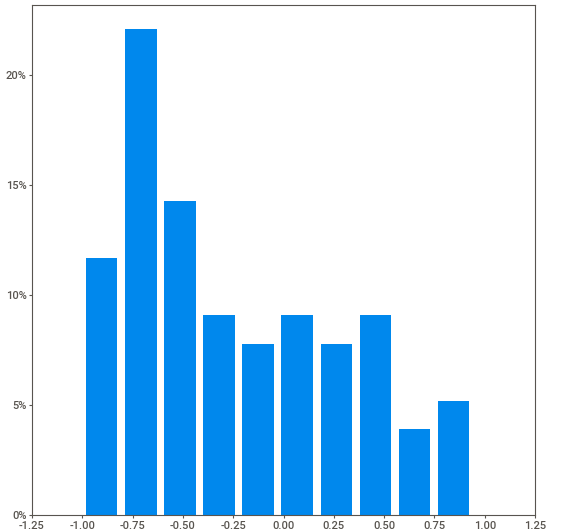
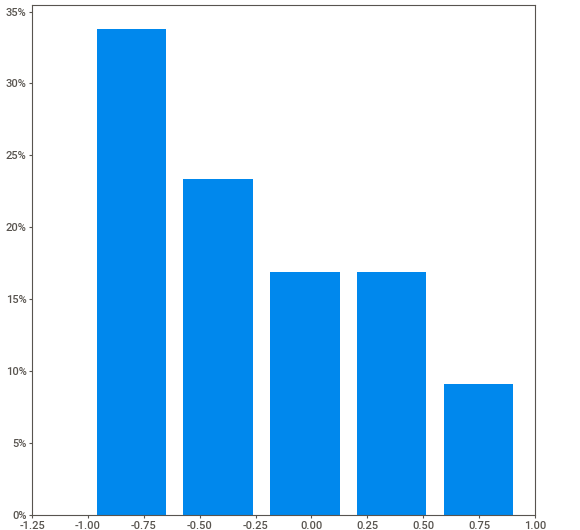
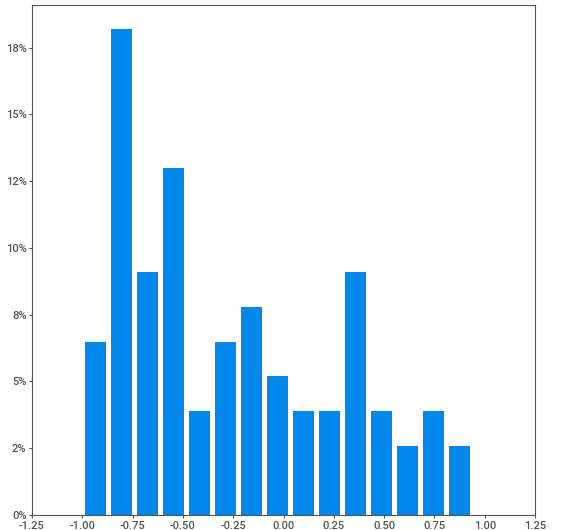
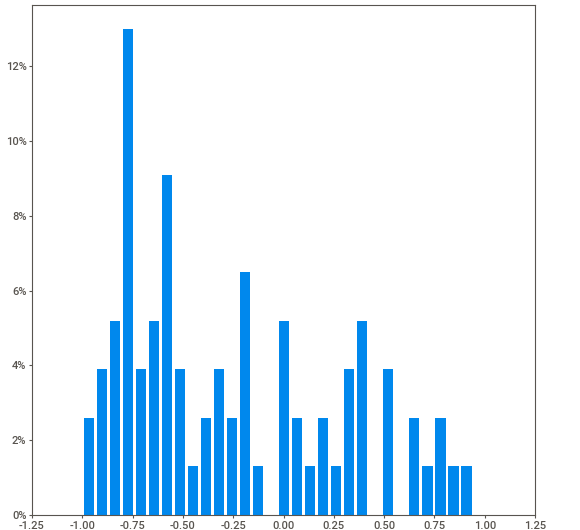
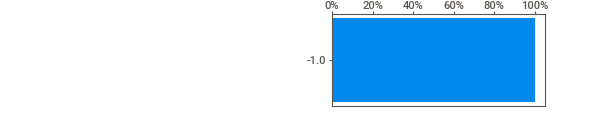
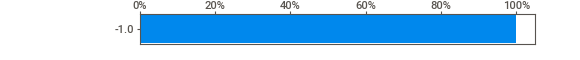
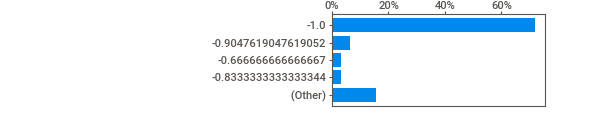
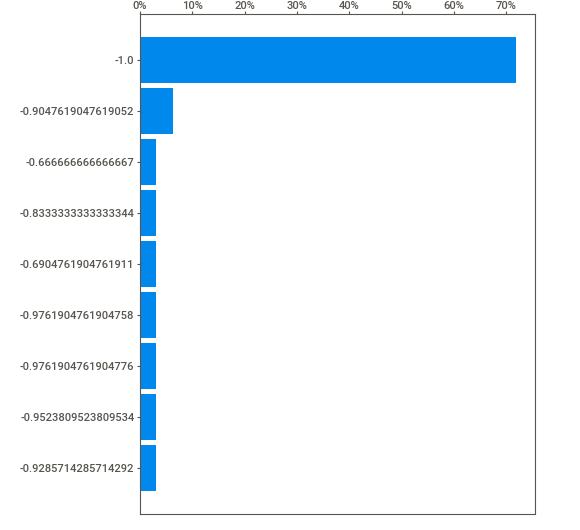
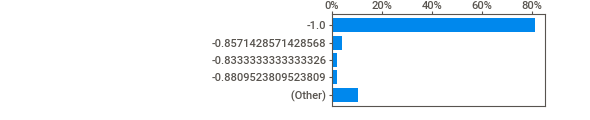
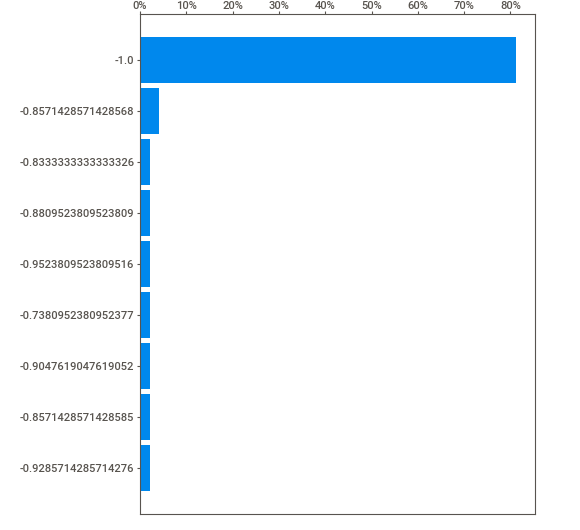
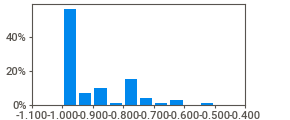
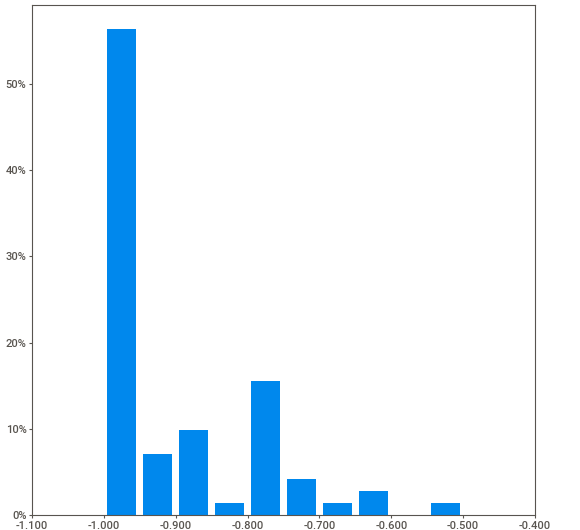
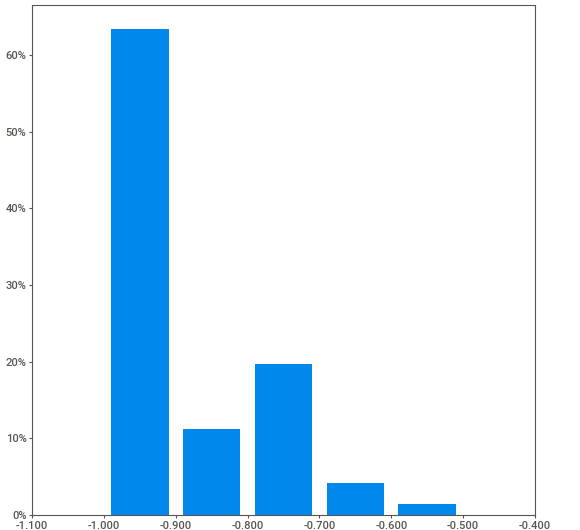
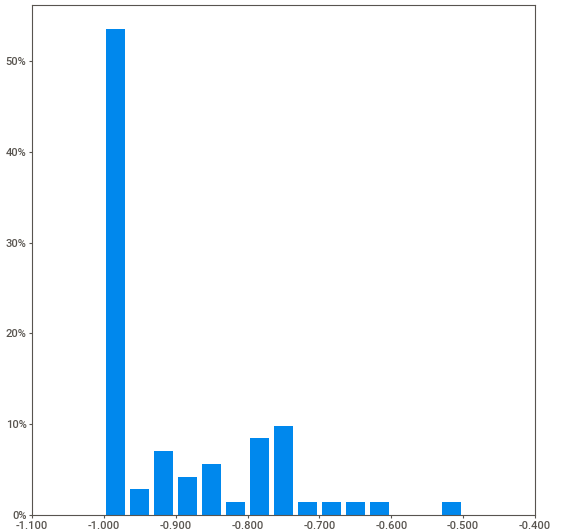
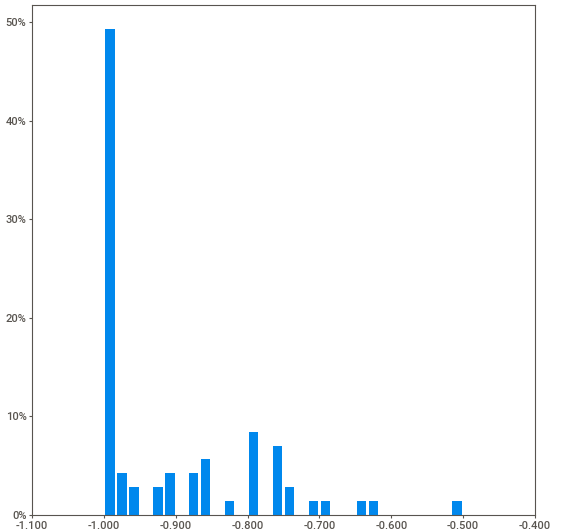
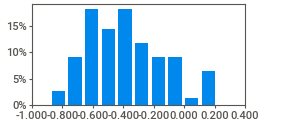
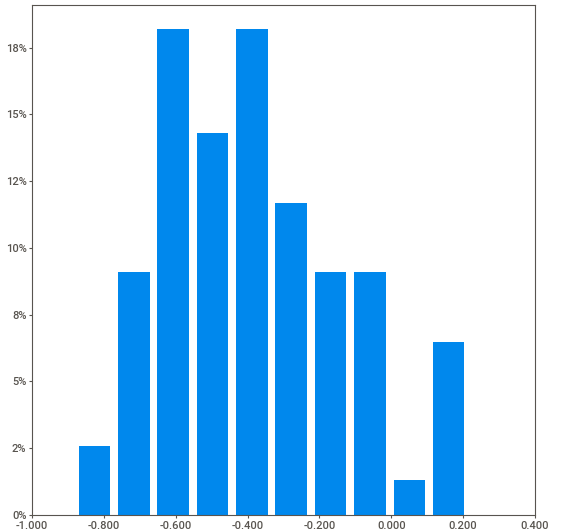
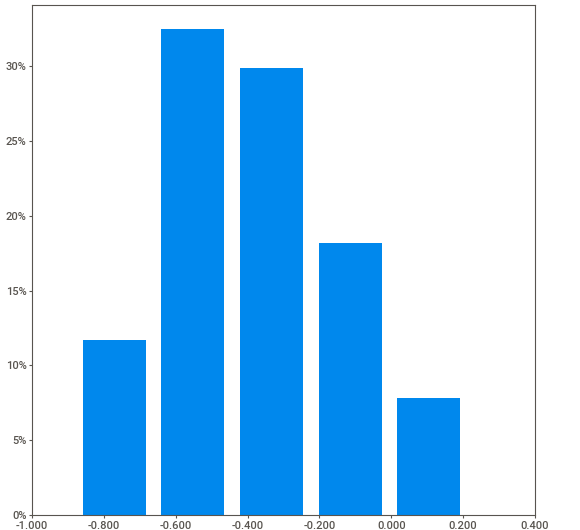
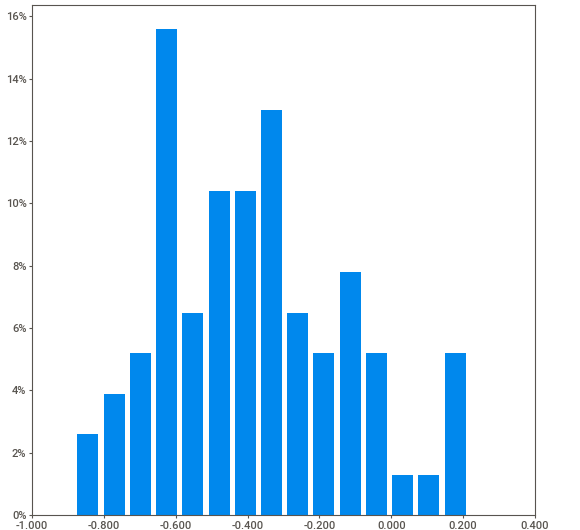
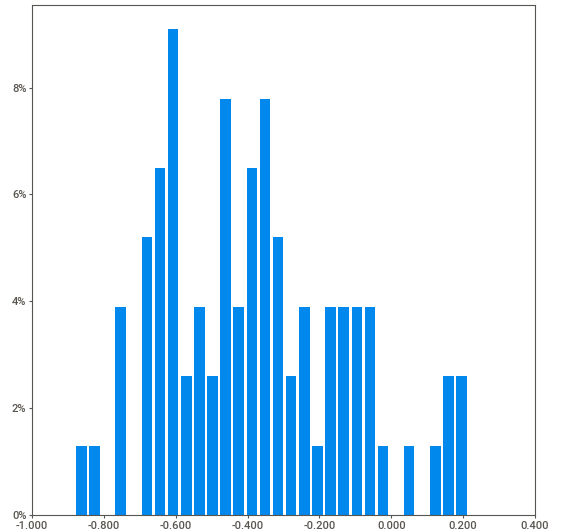
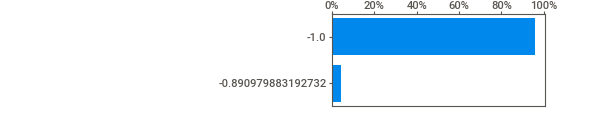
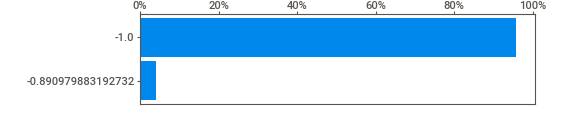
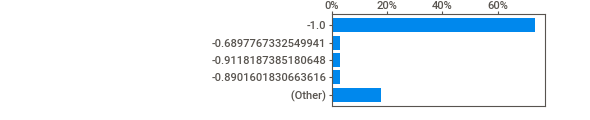
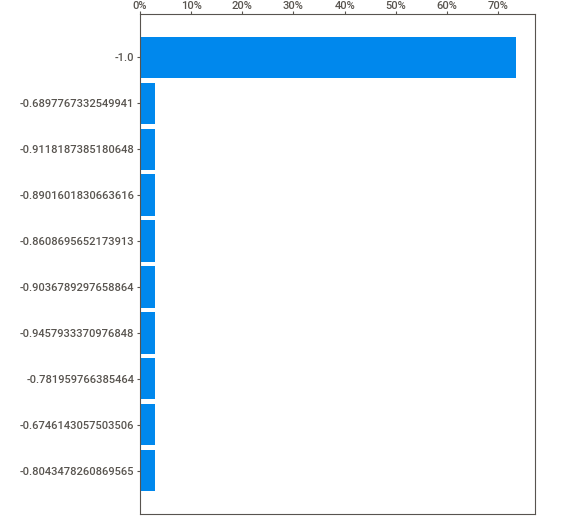
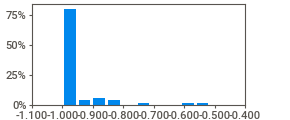
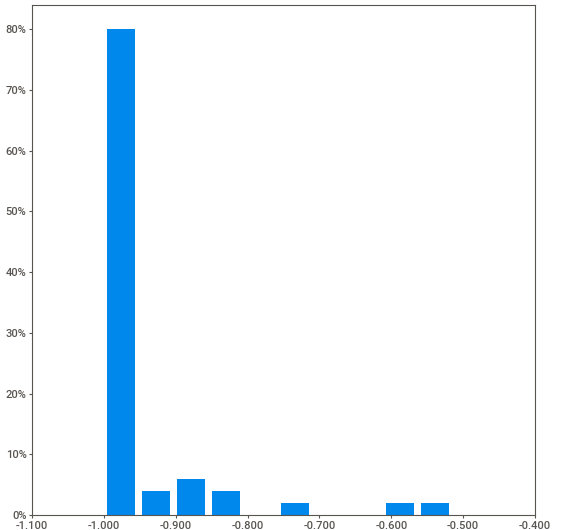
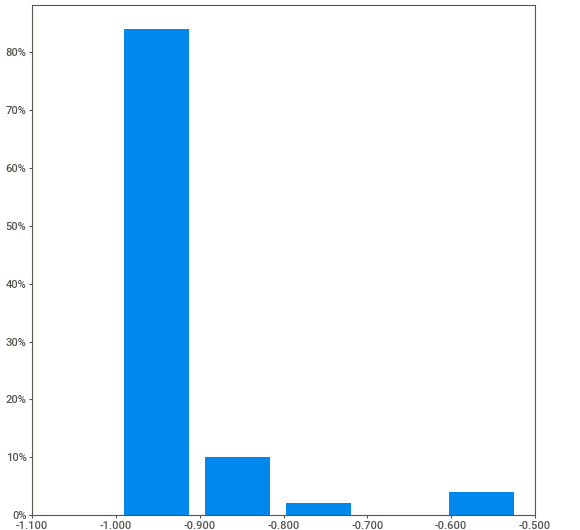
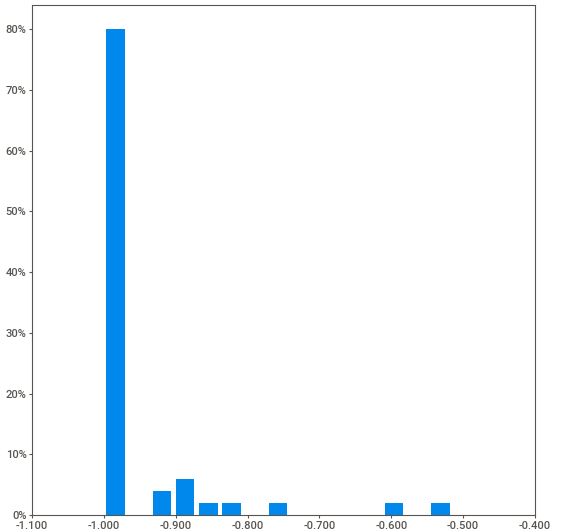
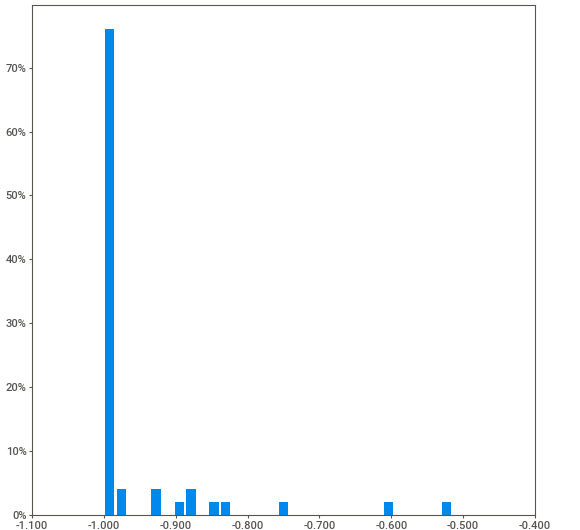
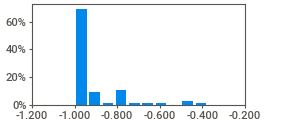
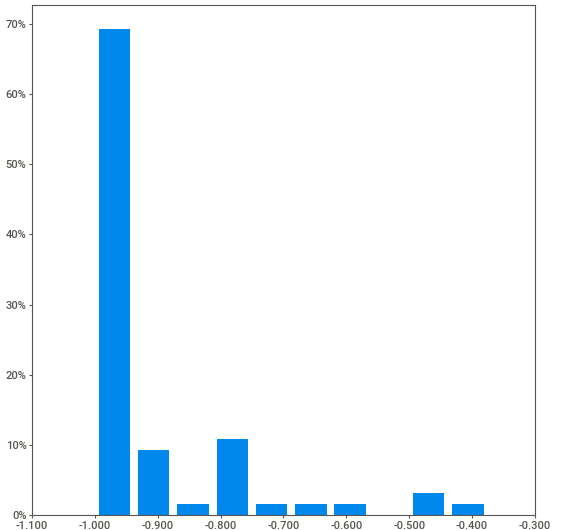
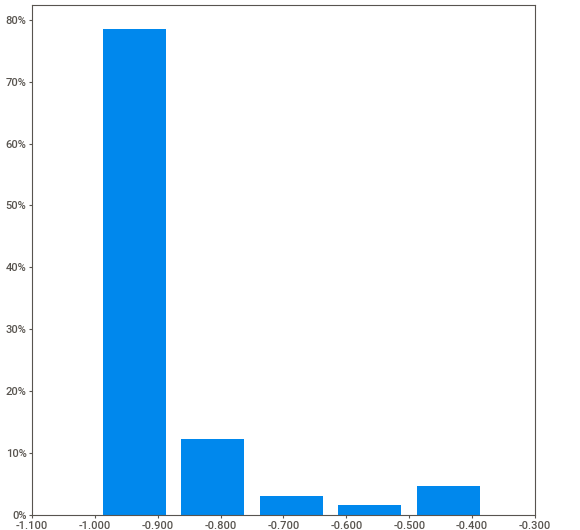
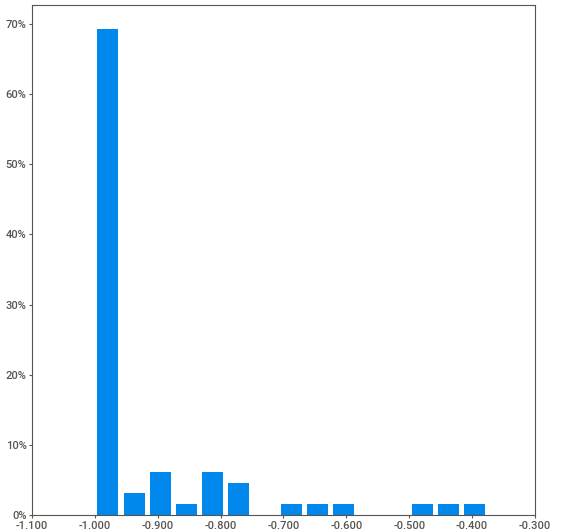
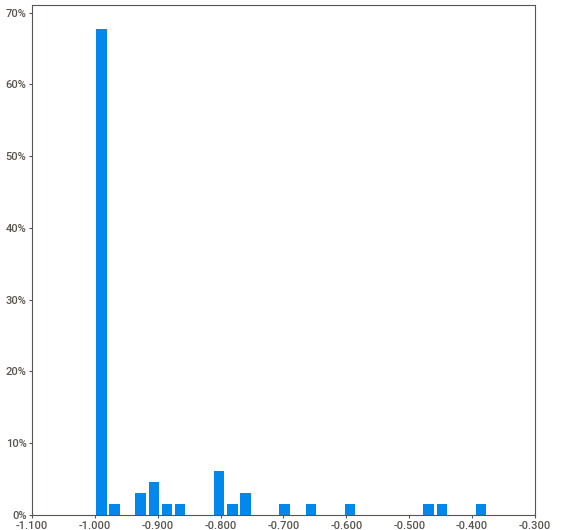
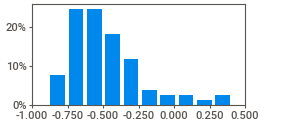
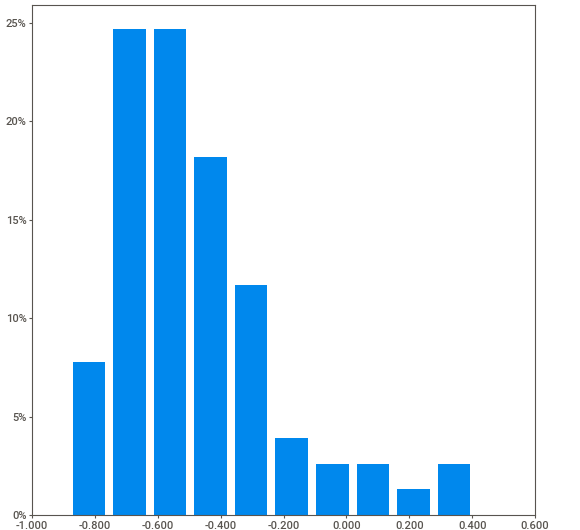
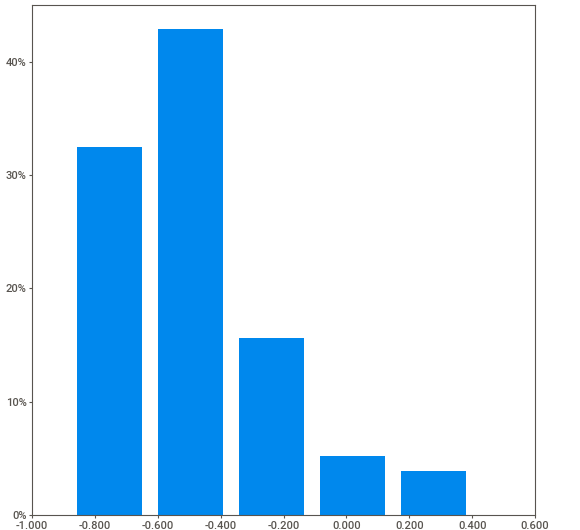
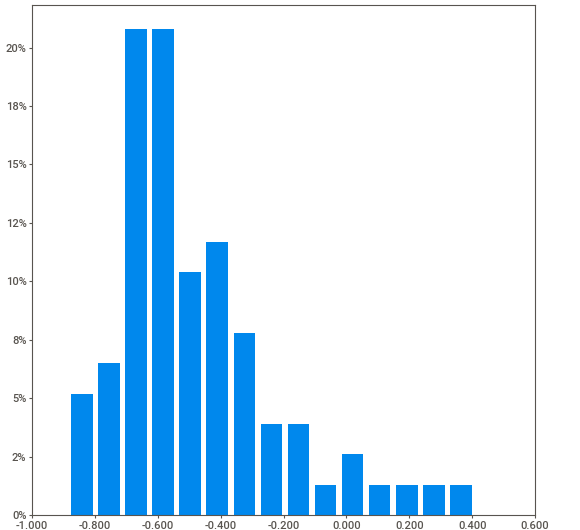
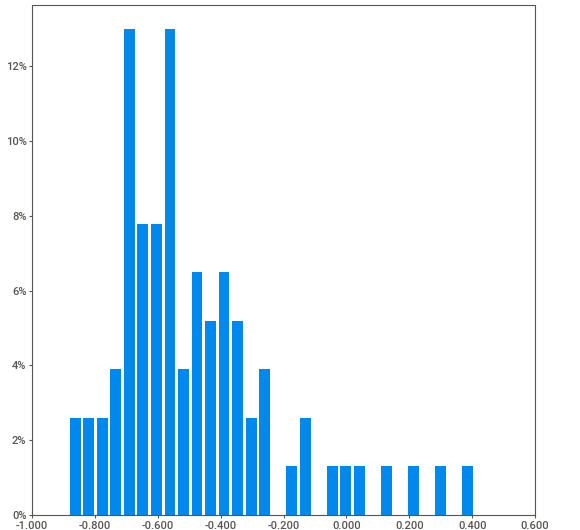
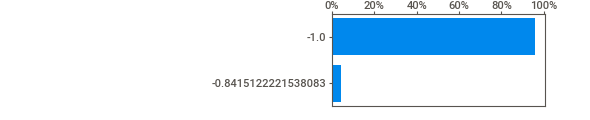
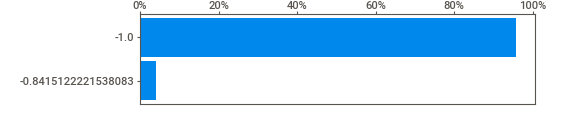
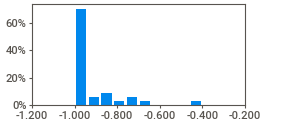
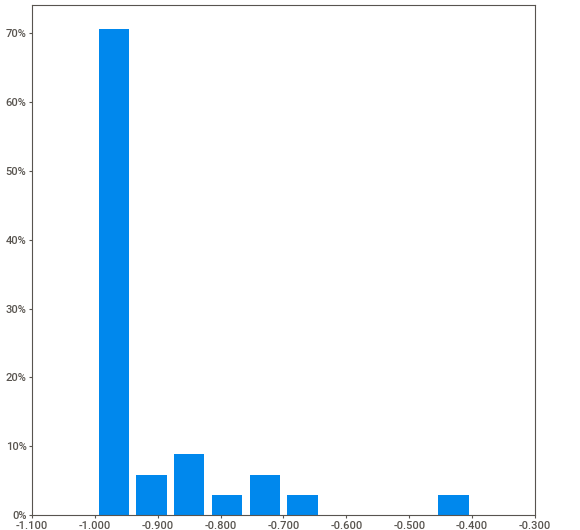
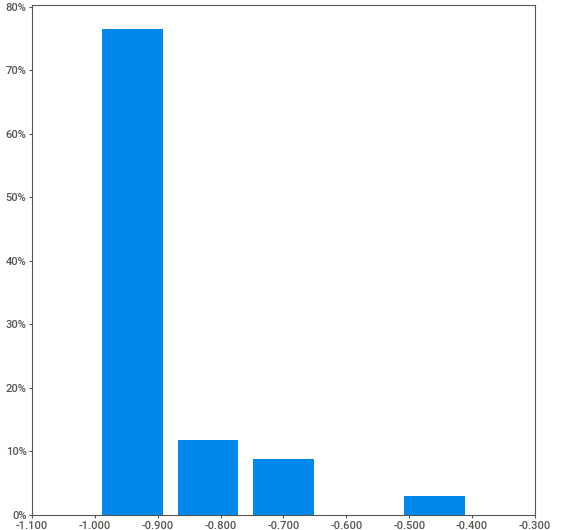
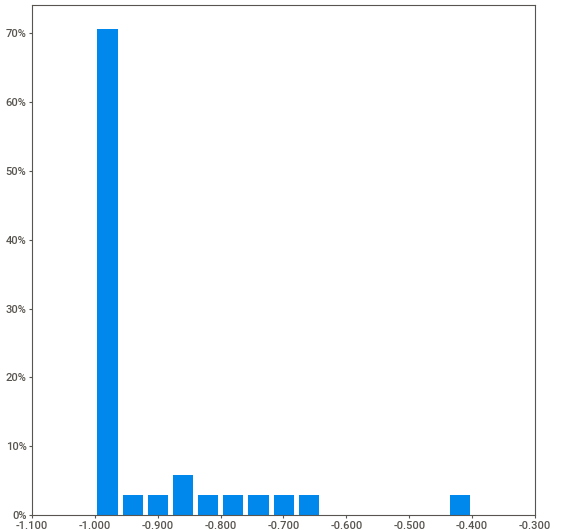
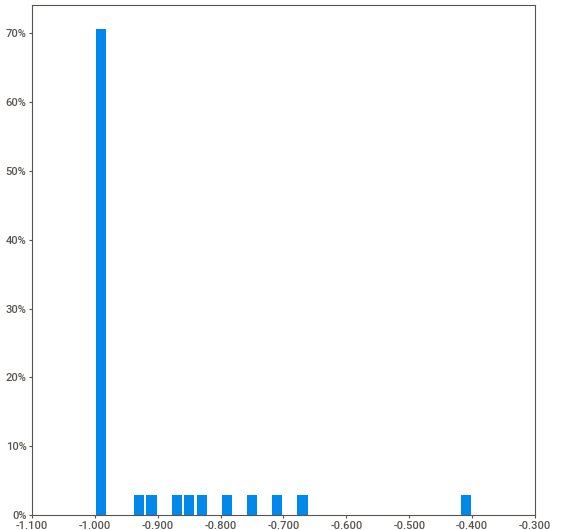
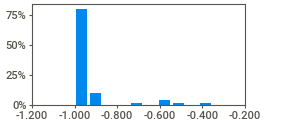
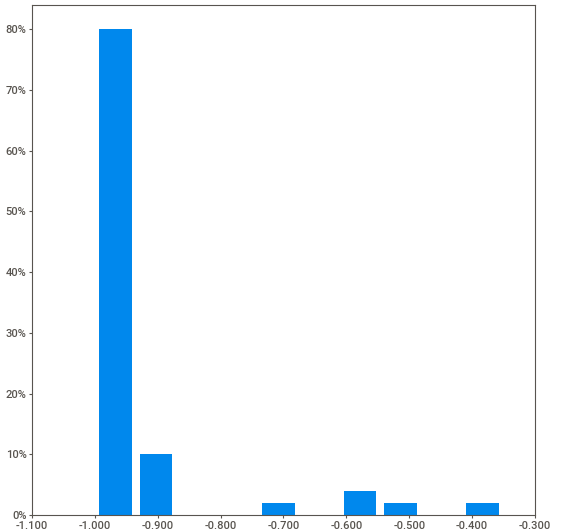
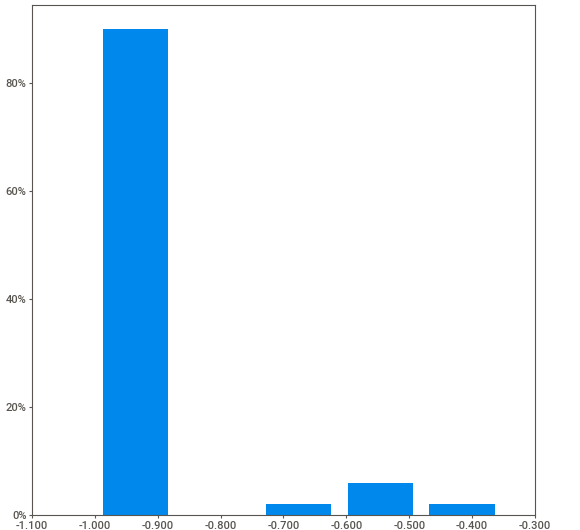
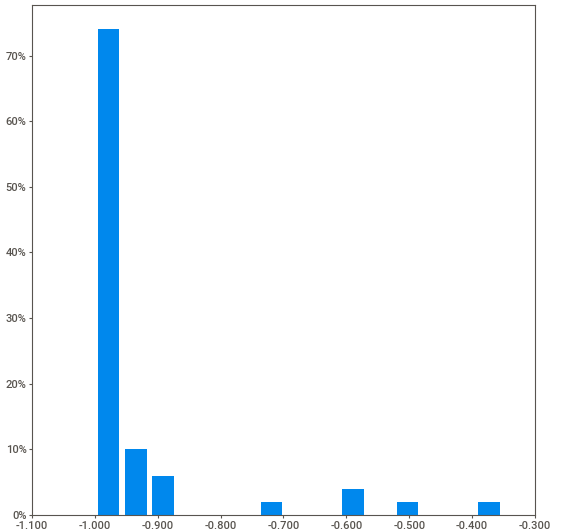
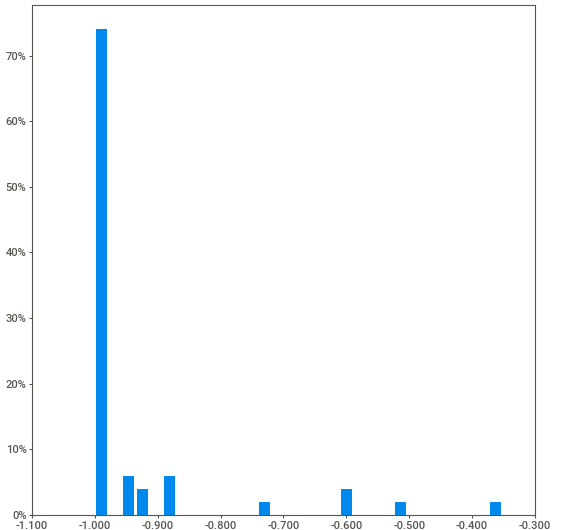
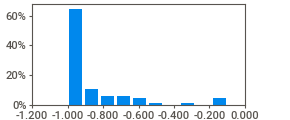
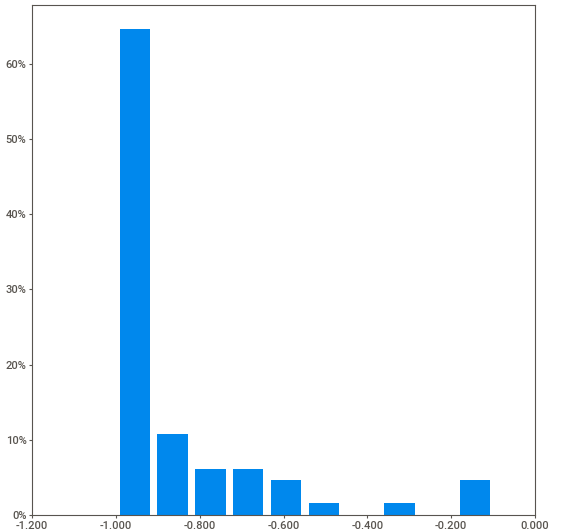
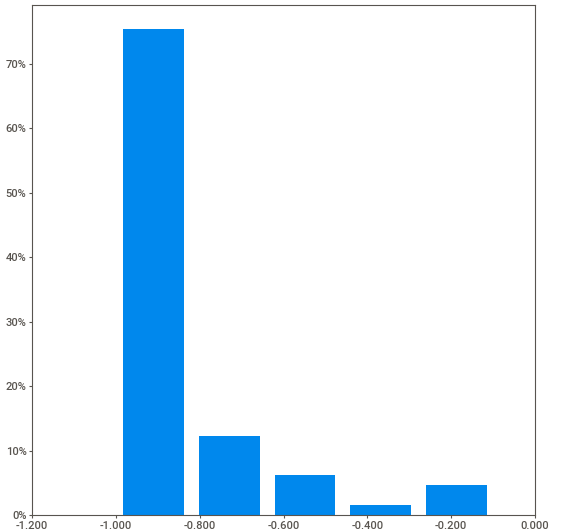
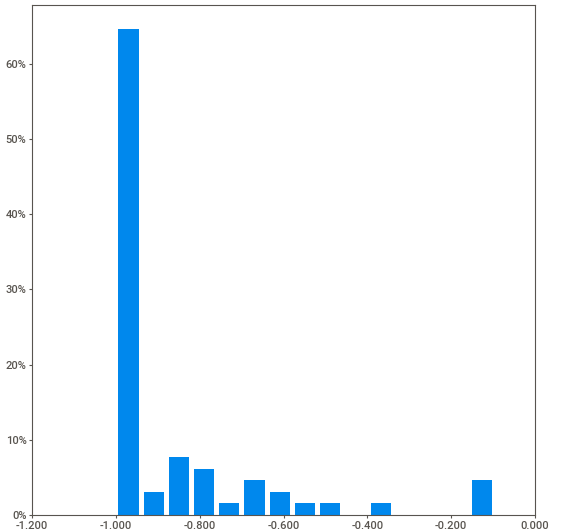
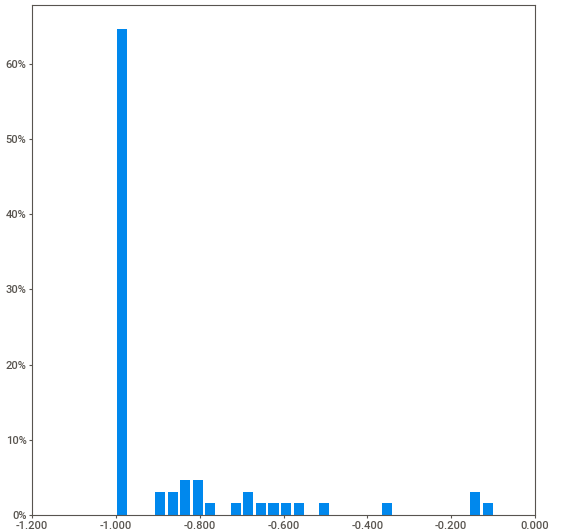
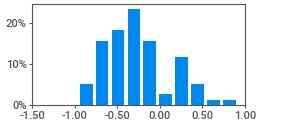
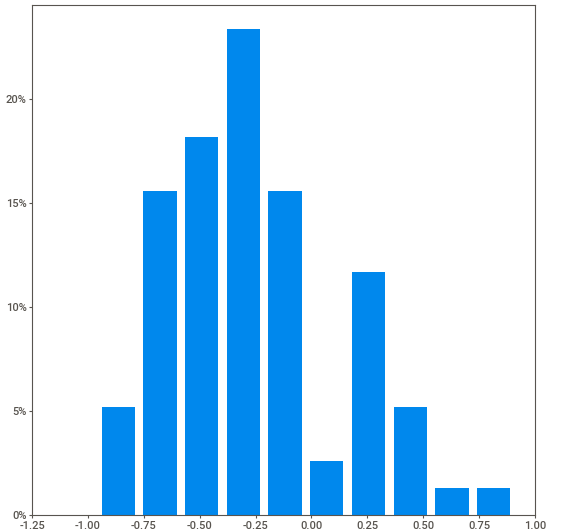
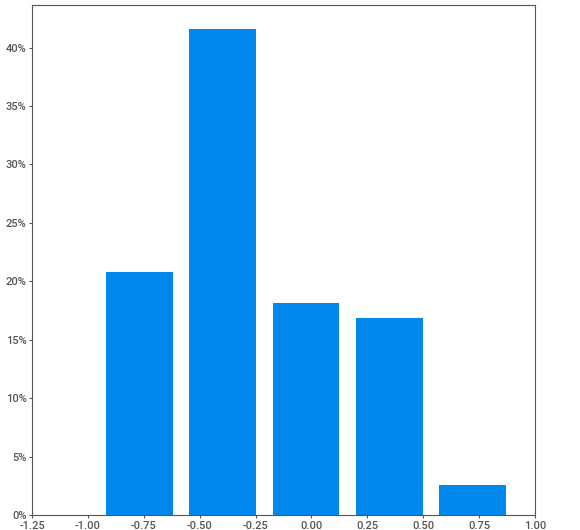
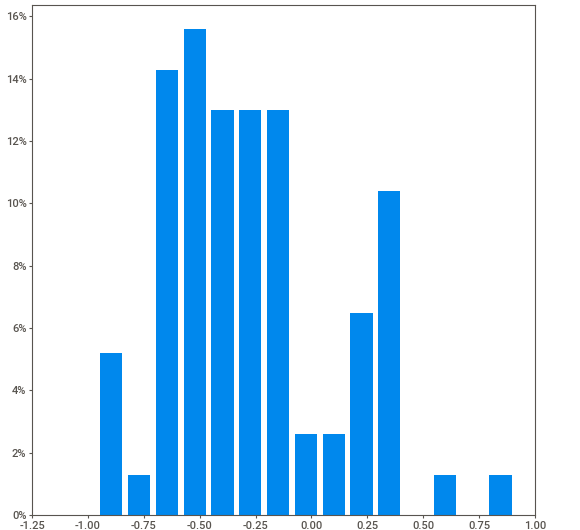
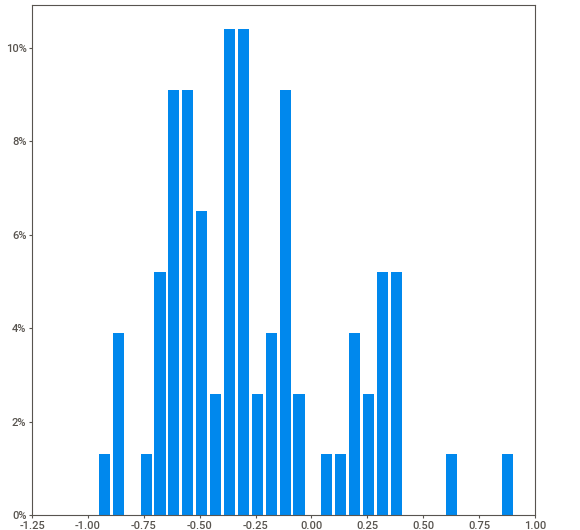
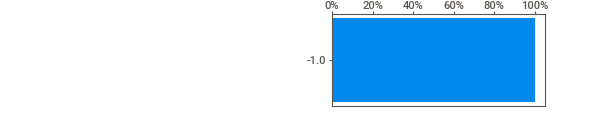
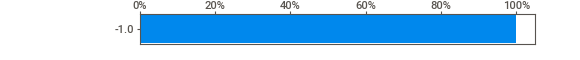
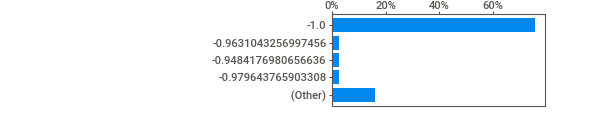
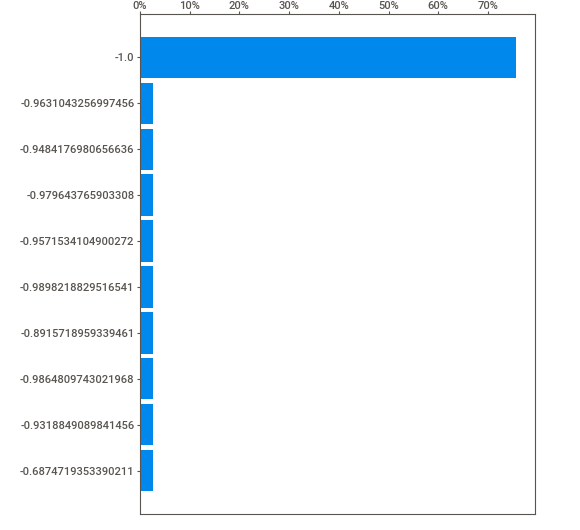
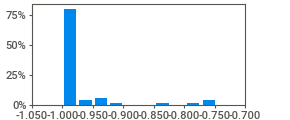
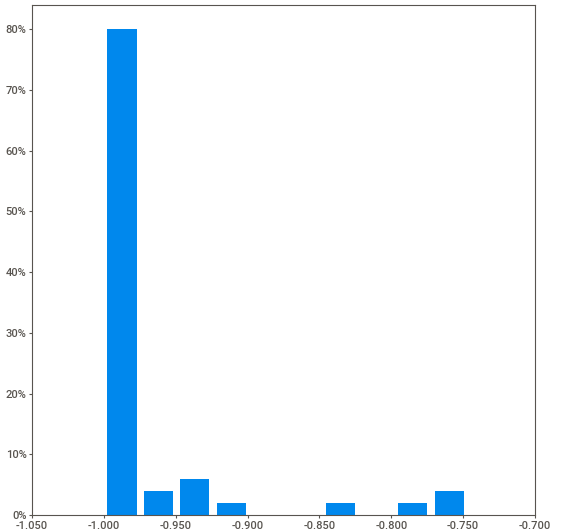
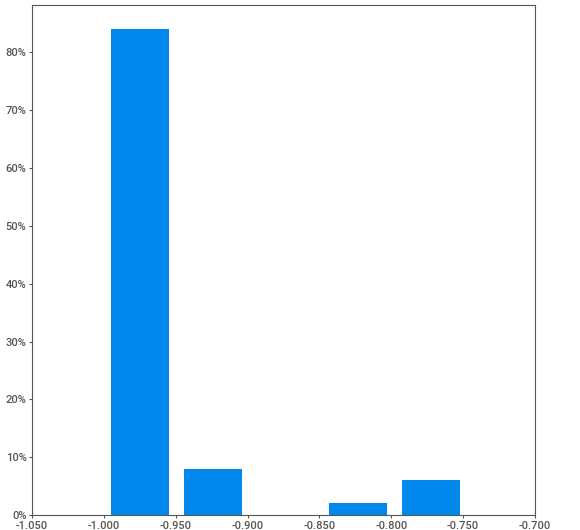
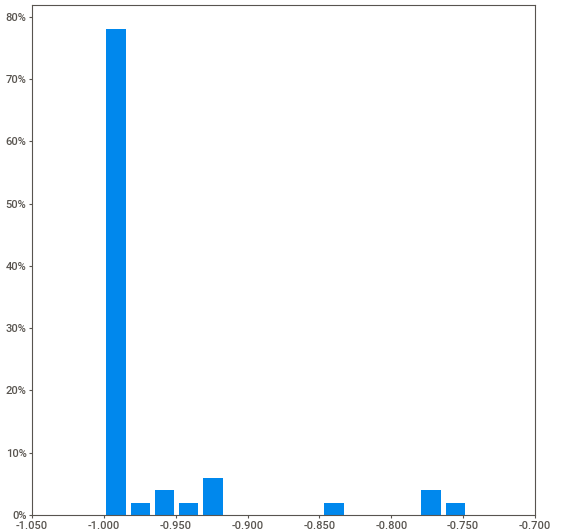
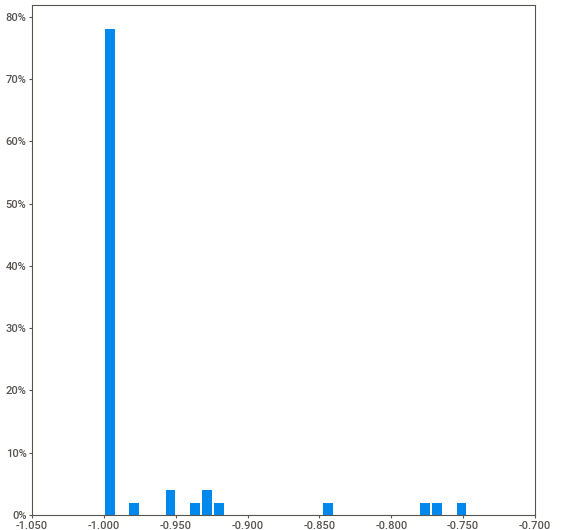
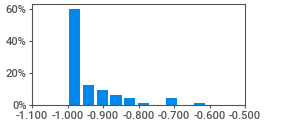
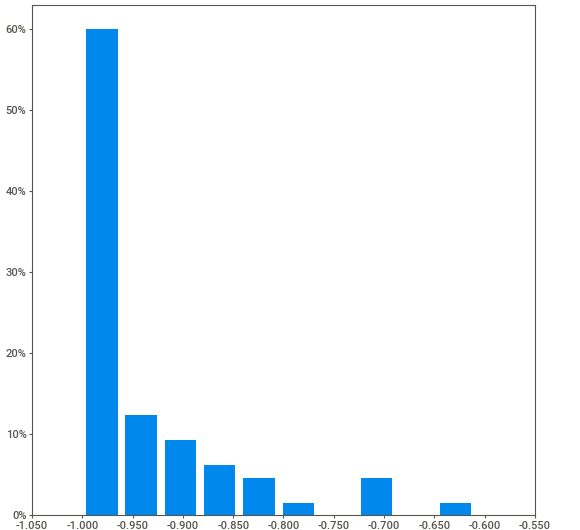
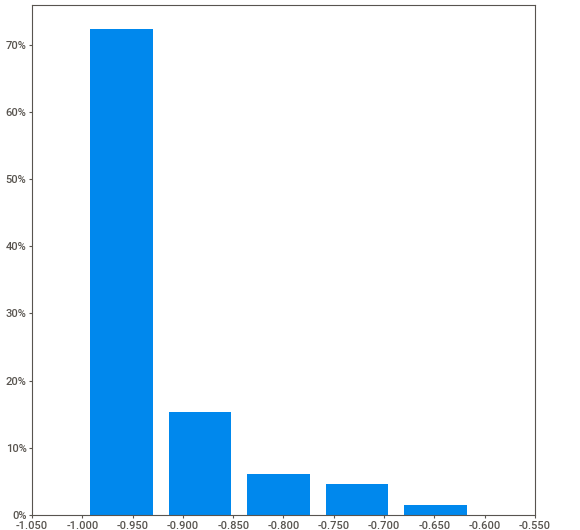
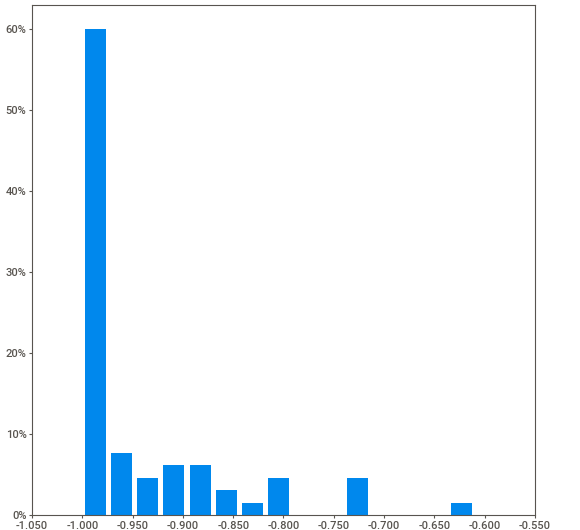
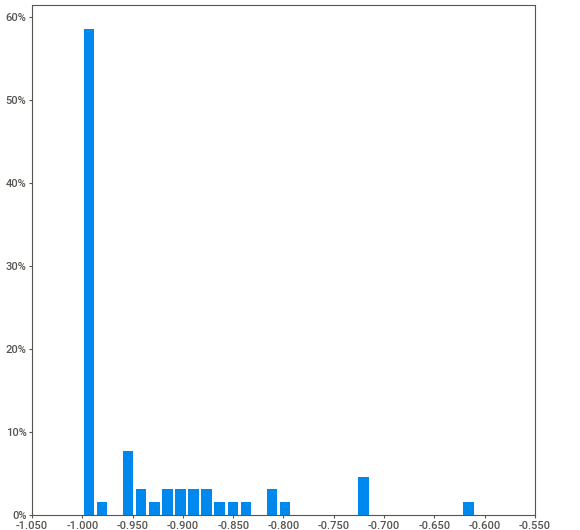
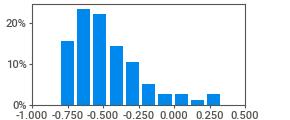
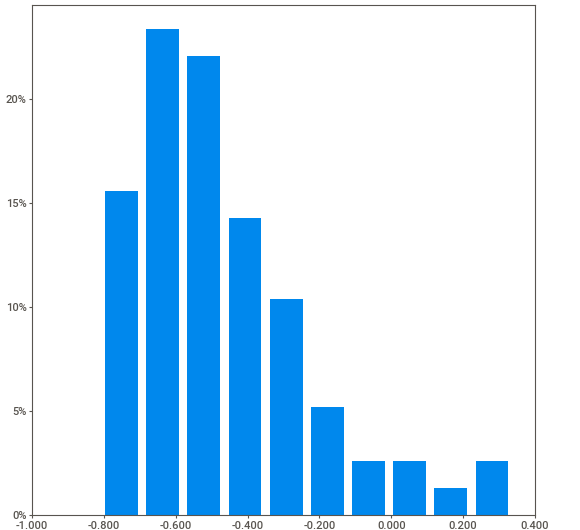
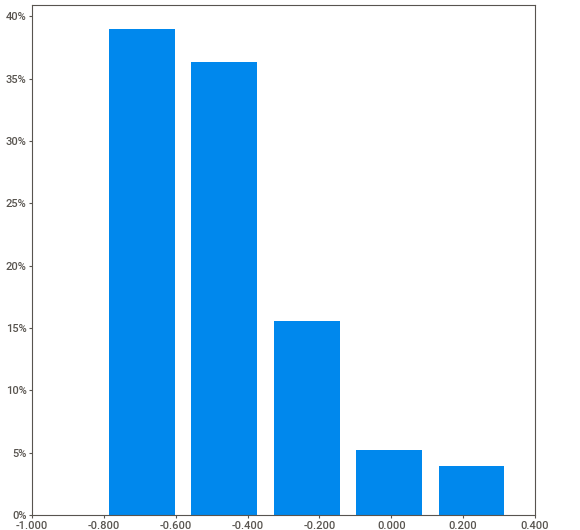
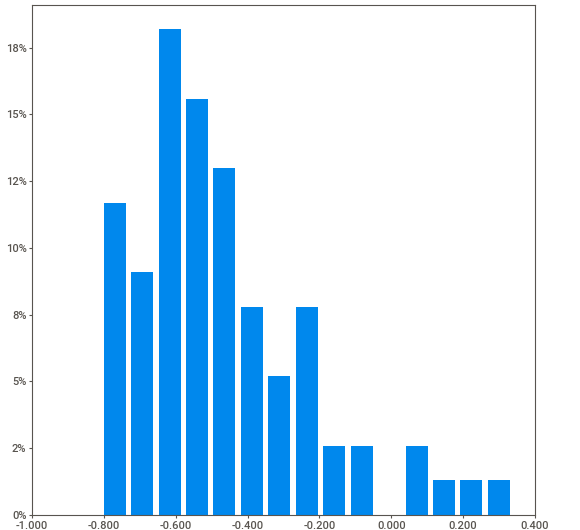
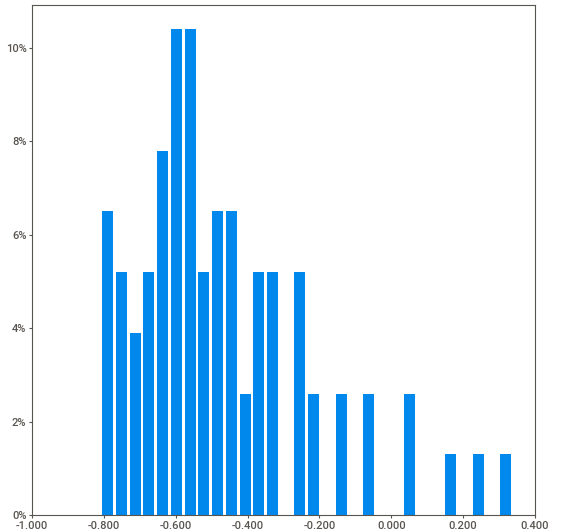
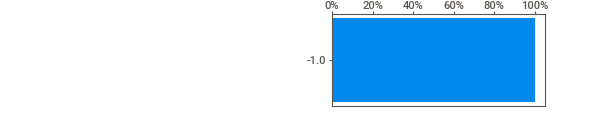
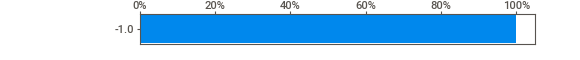
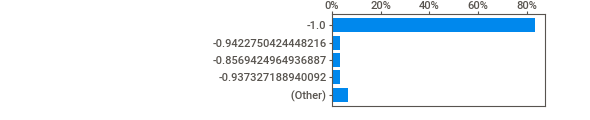
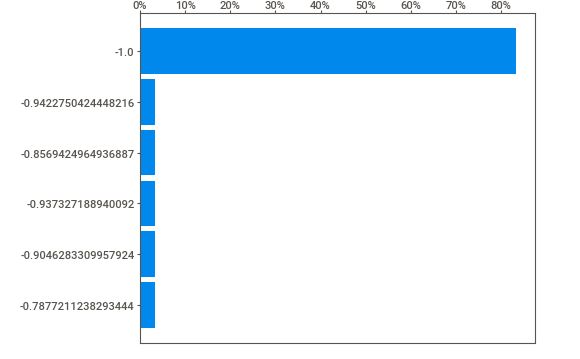
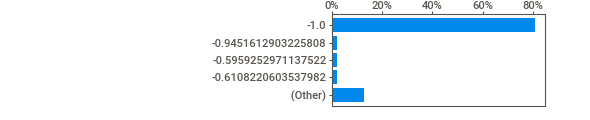
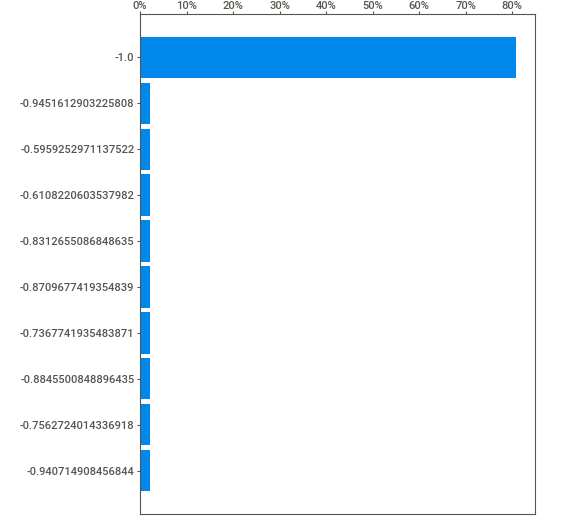
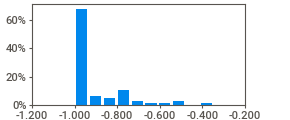
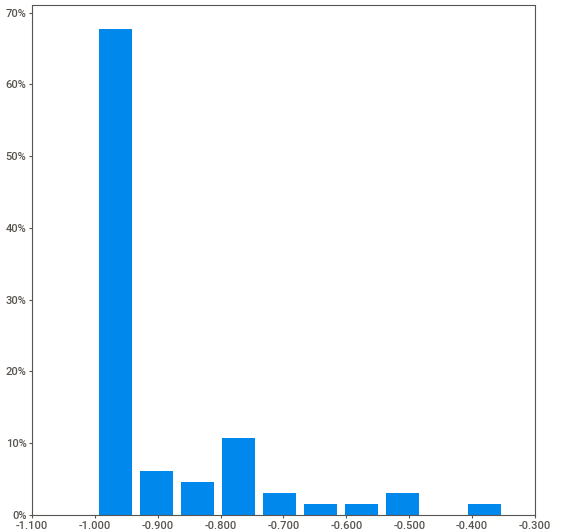
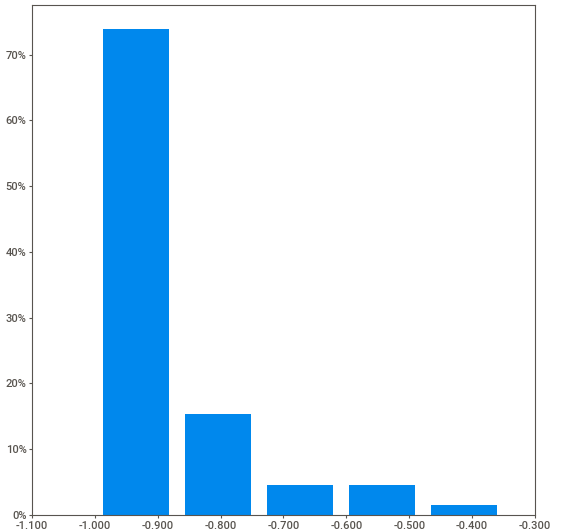
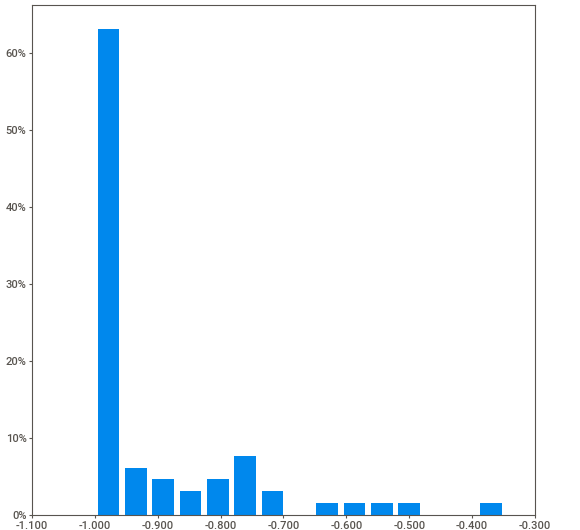
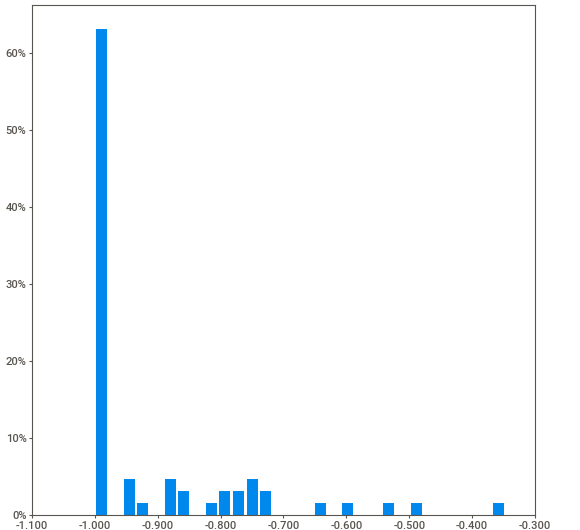
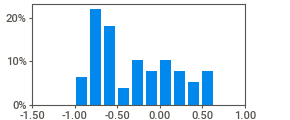
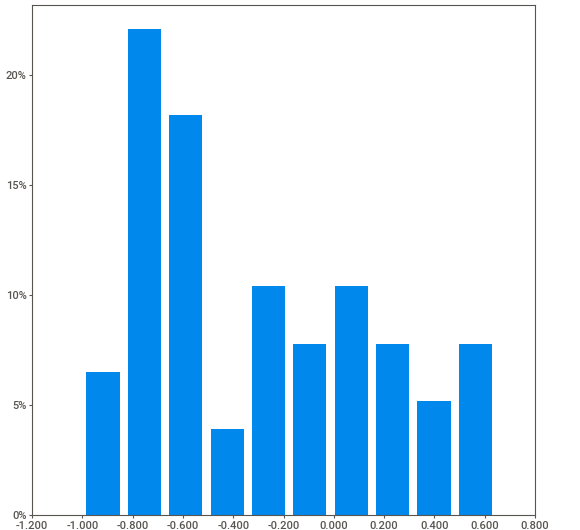
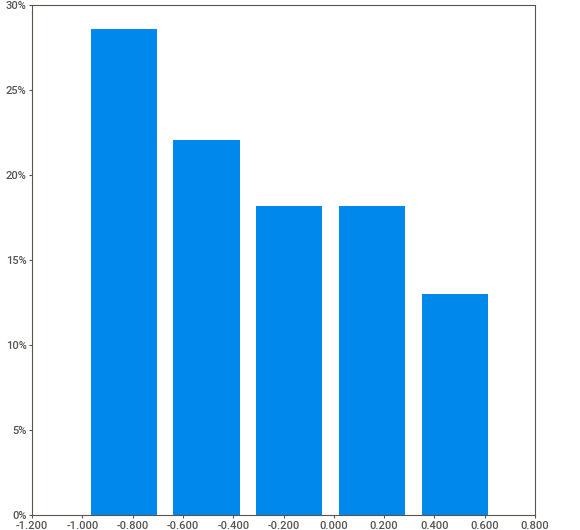
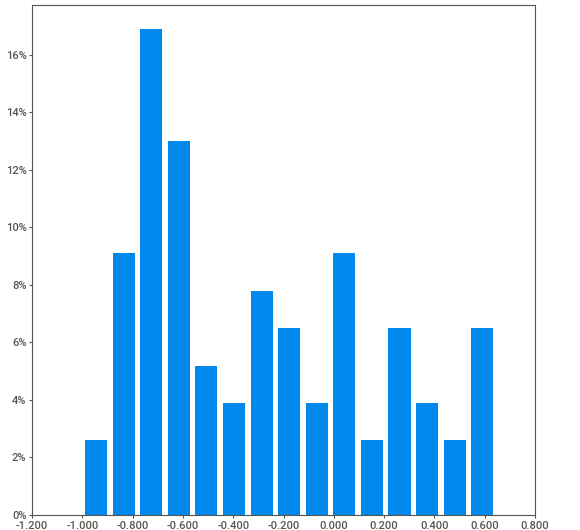
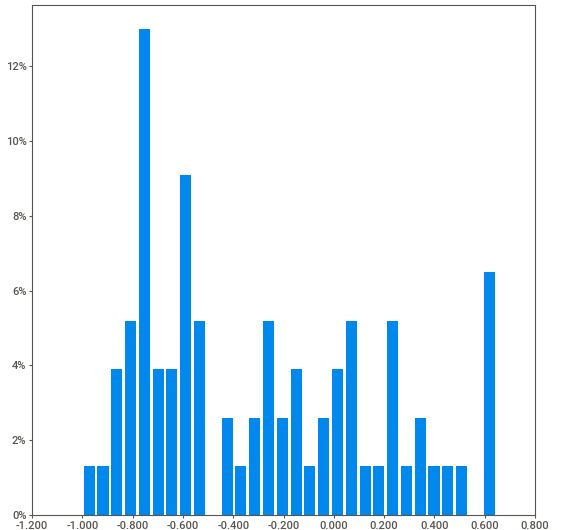
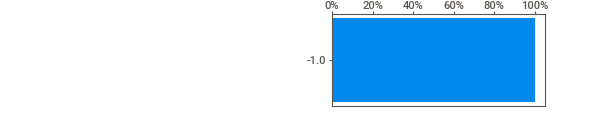
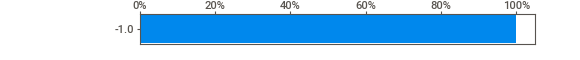
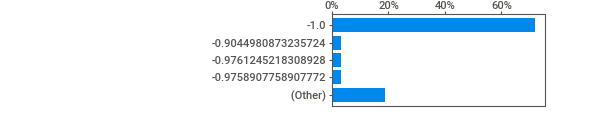
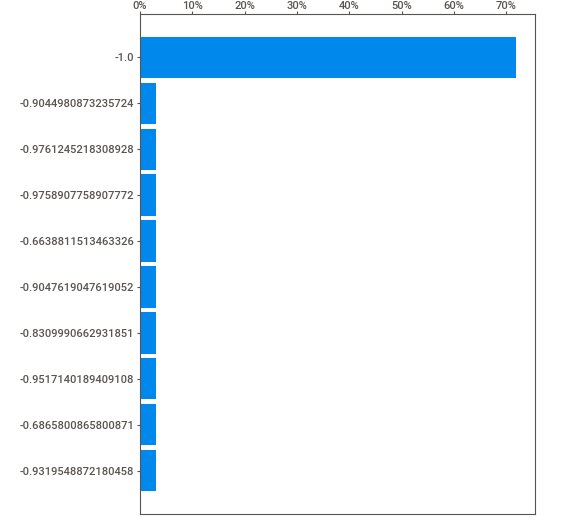
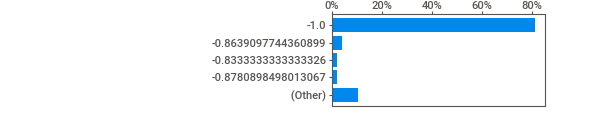
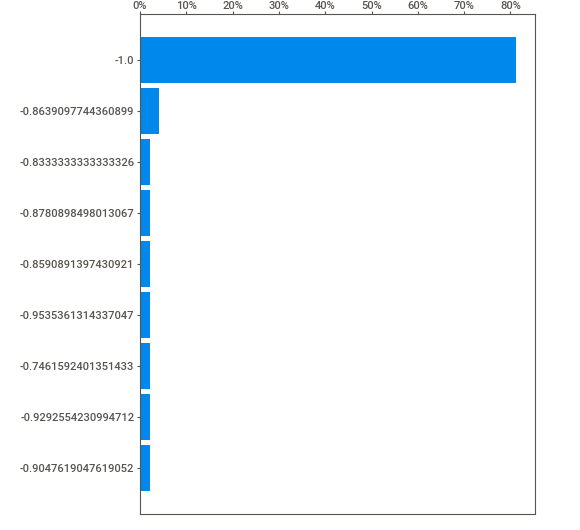
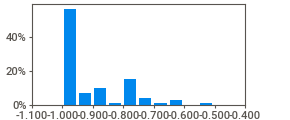
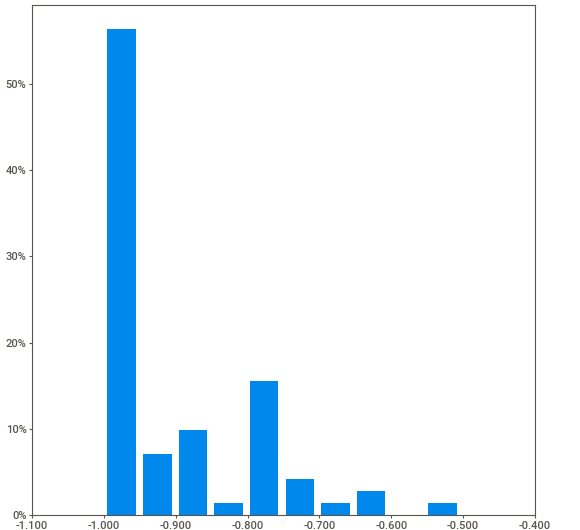
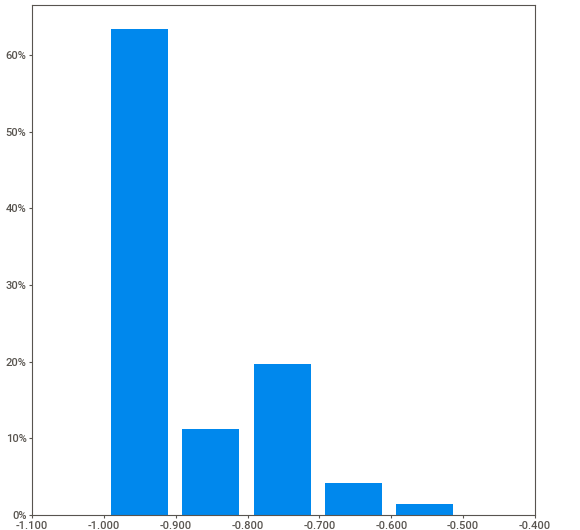
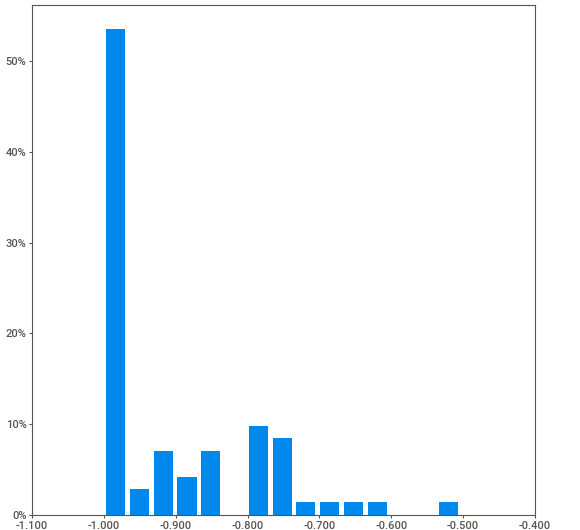
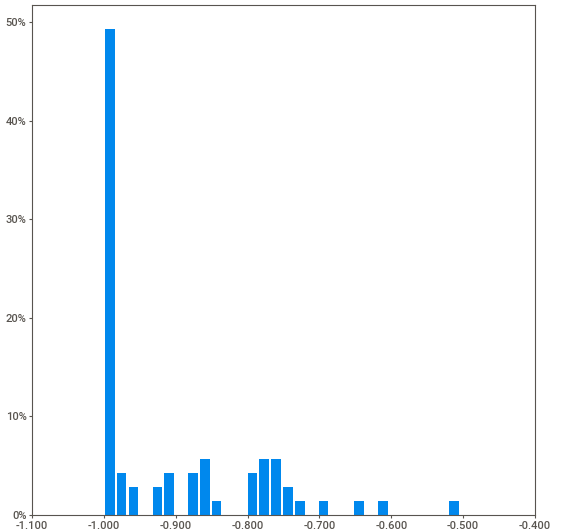
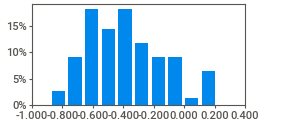
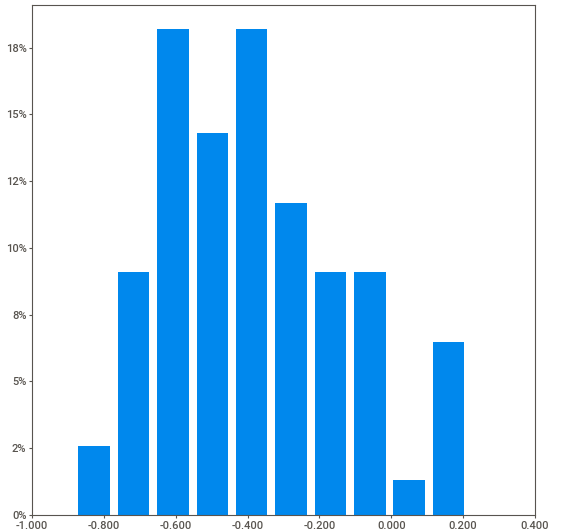
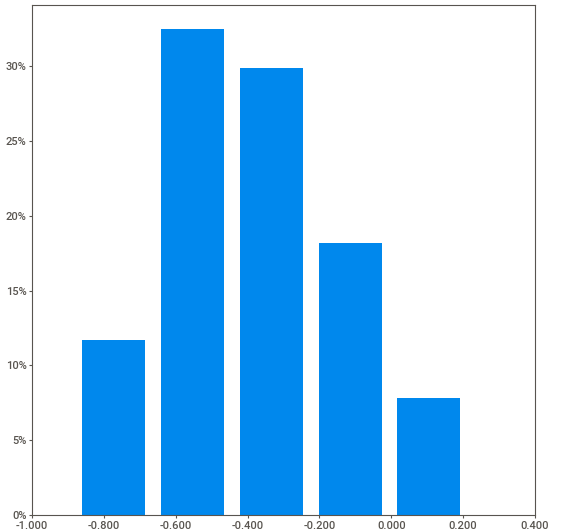
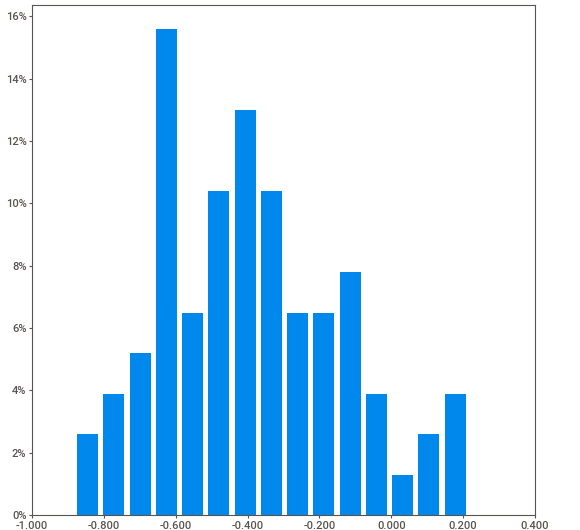
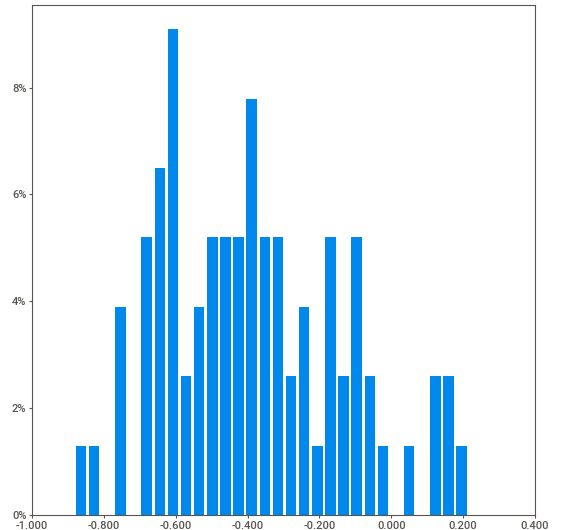
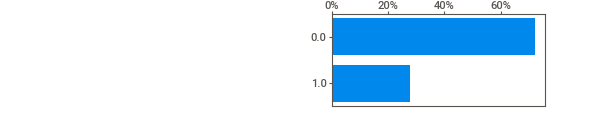
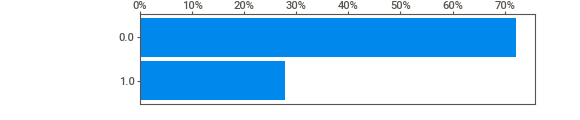
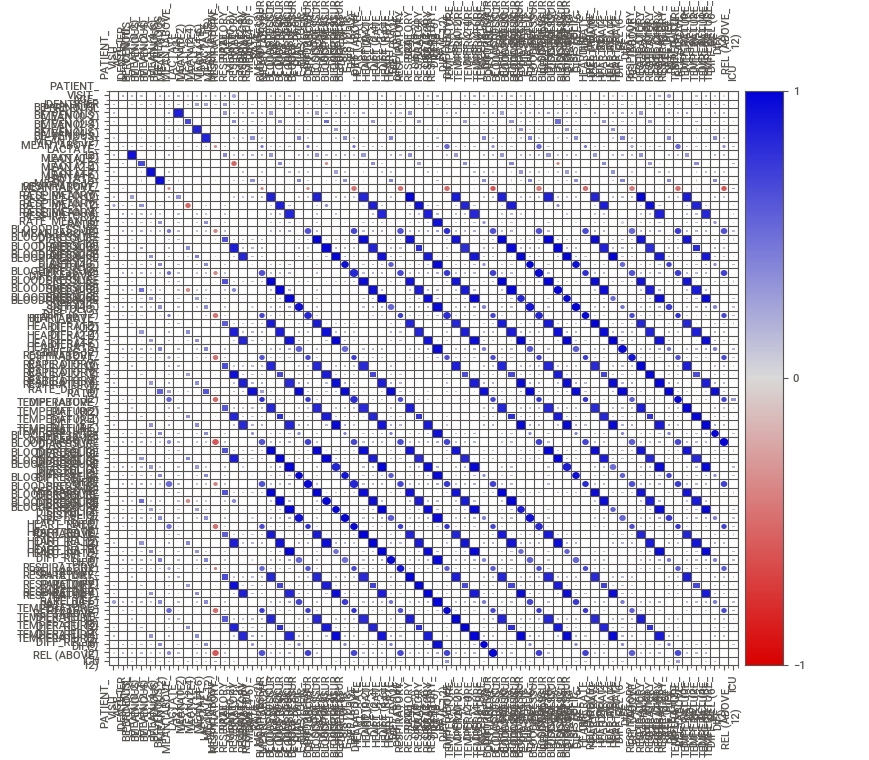
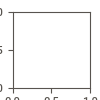

In [62]:
report.show_notebook()

In [43]:
df_evolucao_paciente.columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_PERCENTIL', 'BE_VENOUS_MEAN (0-2)',
       'BE_VENOUS_MEAN (2-4)', 'BE_VENOUS_MEAN (4-6)', 'BE_VENOUS_MEAN (6-12)',
       'BE_VENOUS_MEAN (ABOVE_12)', 'LACTATE_MEAN (0-2)', 'LACTATE_MEAN (2-4)',
       'LACTATE_MEAN (4-6)', 'LACTATE_MEAN (6-12)', 'LACTATE_MEAN (ABOVE_12)',
       'RESPIRATORY_RATE_MEAN (0-2)', 'RESPIRATORY_RATE_MEAN (2-4)',
       'RESPIRATORY_RATE_MEAN (4-6)', 'RESPIRATORY_RATE_MEAN (6-12)',
       'RESPIRATORY_RATE_MEAN (ABOVE_12)',
       'BLOODPRESSURE_DIASTOLIC_DIFF (0-2)',
       'BLOODPRESSURE_DIASTOLIC_DIFF (2-4)',
       'BLOODPRESSURE_DIASTOLIC_DIFF (4-6)',
       'BLOODPRESSURE_DIASTOLIC_DIFF (6-12)',
       'BLOODPRESSURE_DIASTOLIC_DIFF (ABOVE_12)',
       'BLOODPRESSURE_SISTOLIC_DIFF (0-2)',
       'BLOODPRESSURE_SISTOLIC_DIFF (2-4)',
       'BLOODPRESSURE_SISTOLIC_DIFF (4-6)',
       'BLOODPRESSURE_SISTOLIC_DIFF (6-12)',
       'BLOODPRESSURE_SISTOLIC_DIFF (ABOVE_12)', 'HEART_RATE_DIFF (0-2)',
       'HEART_RATE_DI

In [44]:
df_evolucao_paciente['AGE_PERCENTIL_CODE'] = df_evolucao_paciente['AGE_PERCENTIL'].cat.codes
df_evolucao_paciente

PATIENT_VISIT_IDENTIFIER AGE_PERCENTIL  ...  ICU  AGE_PERCENTIL_CODE
0                           0          60th  ...  0.0                   5
1                           1          90th  ...  0.0                   8
2                           2          10th  ...  0.0                   0
3                           3          40th  ...  0.0                   3
4                           4          10th  ...  1.0                   0
..                        ...           ...  ...  ...                 ...
380                       380          40th  ...  0.0                   3
381                       381    Above 90th  ...  0.0                   9
382                       382          50th  ...  0.0                   4
383                       383          40th  ...  0.0                   3
384                       384          50th  ...  0.0                   4

[385 rows x 69 columns]

In [45]:
df_evolucao_paciente['ICU'].value_counts(normalize=True)

0.0    0.722078
1.0    0.277922
Name: ICU, dtype: float64

In [46]:
df_evolucao_paciente.drop(df_evolucao_paciente.loc[df_evolucao_paciente['ICU']==0].sample(171,random_state=5464).index,inplace=True) #171

In [47]:
df_evolucao_paciente['ICU'].value_counts(normalize=True)

1.0    0.5
0.0    0.5
Name: ICU, dtype: float64

In [48]:
X=df_evolucao_paciente.drop(columns=['AGE_PERCENTIL','PATIENT_VISIT_IDENTIFIER','ICU'])
y=df_evolucao_paciente['ICU']

In [49]:
X.fillna(999,inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 2 to 383
Data columns (total 66 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   BE_VENOUS_MEAN (0-2)                         214 non-null    float64
 1   BE_VENOUS_MEAN (2-4)                         214 non-null    float64
 2   BE_VENOUS_MEAN (4-6)                         214 non-null    float64
 3   BE_VENOUS_MEAN (6-12)                        214 non-null    float64
 4   BE_VENOUS_MEAN (ABOVE_12)                    214 non-null    float64
 5   LACTATE_MEAN (0-2)                           214 non-null    float64
 6   LACTATE_MEAN (2-4)                           214 non-null    float64
 7   LACTATE_MEAN (4-6)                           214 non-null    float64
 8   LACTATE_MEAN (6-12)                          214 non-null    float64
 9   LACTATE_MEAN (ABOVE_12)                      214 non-null    float64
 10  RE

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=546,test_size=0.2)

In [51]:
print(f'X_train: {len(X_train)}')
print(f'X_test: {len(X_test)}')
print(f'y_train: {len(y_train)}')
print(f'y_test: {len(y_test)}')

X_train: 171
X_test: 43
y_train: 171
y_test: 43


In [52]:
print('### y_train ###')
print(y_train.value_counts(normalize=True))
print('\n### y_test ###')
print(y_test.value_counts(normalize=True))

### y_train ###
1.0    0.508772
0.0    0.491228
Name: ICU, dtype: float64

### y_test ###
0.0    0.534884
1.0    0.465116
Name: ICU, dtype: float64


In [53]:
clf = MLPClassifier(activation='tanh',
    solver='adam', 
hidden_layer_sizes=(X_train.shape[1], int(X_train.shape[1]*0.65),int(X_train.shape[1]*0.45),int(X_train.shape[1]*0.25)), 
random_state=5465,verbose=True,max_iter=15,validation_fraction=0.7,learning_rate='adaptive'
)

In [54]:
clf.fit(X_train, y_train)

Iteration 1, loss = 0.70998099
Iteration 2, loss = 0.67283434
Iteration 3, loss = 0.64771055
Iteration 4, loss = 0.63535248
Iteration 5, loss = 0.62838342
Iteration 6, loss = 0.62074510
Iteration 7, loss = 0.61172226
Iteration 8, loss = 0.60509556
Iteration 9, loss = 0.60758389
Iteration 10, loss = 0.58925770
Iteration 11, loss = 0.57957180
Iteration 12, loss = 0.57698817
Iteration 13, loss = 0.57096375
Iteration 14, loss = 0.56804405
Iteration 15, loss = 0.56468182


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(66, 42, 29, 16), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=15,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=5465, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.7, verbose=True,
              warm_start=False)

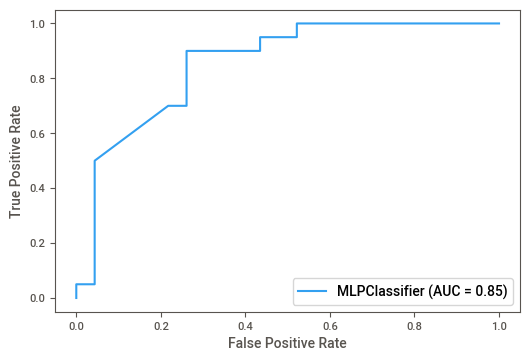

In [55]:
ax = plt.gca()
clf_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)

In [56]:
y_pred =clf.predict(X_test)
y_pred

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 1.])

In [57]:
y_test.values

array([1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0.])

In [58]:
print('Accuracy score: {0:0.2f}%'.format(100*accuracy_score(y_test, y_pred)))

Accuracy score: 79.07%


In [59]:
y_score = clf.predict(X_test)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.3f}%'.format(100*average_precision))

Average precision-recall score: 69.803%


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.70')

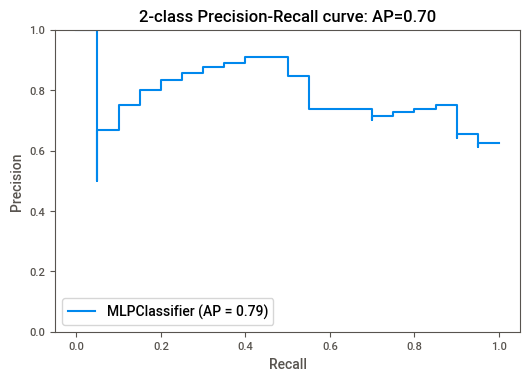

In [65]:
disp = plot_precision_recall_curve(clf, X_test, y_test)
plt.ylim([0.0, 1.0])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))